In [1]:
from os.path import join as ospj
from copy import deepcopy

In [2]:
### If using Colab, uncomment the two following lines to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')


### If using Colab, change the PROJECT_ROOT to where you've uploaded the project.
### E.g. PROJECT_ROOT='/content/drive/MyDrive/TeamX/'
### You may also need to change the `data_dir`, `save_dir`, paths in the `cfgs/exercise_3/` configs.

PROJECT_ROOT='/content/drive/MyDrive/HLCV_stuff/Assignment_3'
import sys
sys.path.append(PROJECT_ROOT)

Mounted at /content/drive


In [ ]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2

In Exercise 3, you will implement a convolutional neural network to perform image classification and explore methods to improve the training performance and generalization of these networks.
We will use the CIFAR-10 dataset as a benchmark for our networks, similar to the previous exercise. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to implement a convolutional network to classify these images using the PyTorch library. The four questions are,

- Implementing a convolutional neural network, training it, and visualizing its weights (Question 1).
- Experiment with batch normalization and early stopping (Question 2).
- Data augmentation and dropout to improve generalization (Question 3).
- Implement transfer learning from an ImageNet-pretrained model (Question 4).

Before we begin, here are a few remarks regarding the codebase for this assignment.


For every experiment, you would define a config dictionary (see the dictionary in `./cfgs/exercise_3/cnn_cifar10.py`). Every config dictionary, will have the configuration for
- data (e.g batch size, shuffle, which DataModule to use, splitting)
- model (e.g which class module to use and what arguments to pass to it)
- training (e.g type of optimizer, lr_scheduler, n_epochs etc.)

The DataModules are located at  `src/data_loaders/` and they inherit from a base_data_module that handles things such as splitting the data (see `src/data_loaders/base_data_modules.py`). A sample datamodule may inherit from this class (e.g `src/data_loaders/data_modules.py`). The main concern is that datamodule initialization should get everything ready, so that one can simply get the dataloaders for train/held-out sets from it (see `get_loader` and `get_heldout_loader` in BaseDataModule). The data augmentations are also done in a preset fation. One defines the preset in `utils/transform_presets.py` and simply specifies the *preset key* in the config for datamodule.

The models are defined in `src/models/` (see for instance `src/models/cnn/model.py`). These are typical Pytorch nn.Modules that we had also seen in Assignment 2. They might additionally have extra methods such as `VisualizeFilter` in `model.py`.

The Traier glues everything together. It creates the model, sets up optimizer, lr_schduler etc. and has the option to `train()` or `evaluate()` a model over the given dataloaders. It also logs everything in `Logs/YOUR_EXP_NAME.log` and saves the checkpoints under the `Saved/YOUR_EXP_NAME/`. Please familirize yourself with the `__init__` and methods of both `trainers/base_trainer.py` and `trainers/cnn_trainer.py` before continuing with the assignment.

Lastly, for tracking different metrics (top(1/5) (train/val) accuracy or losses), we use a MetricTracker object defined in `src/utils/utils.py`. A single tracker keeps track of multiple metric keys and can `update()` their history by adding new values to a list. In the end, it can be used to return an average of a metric.


Feel free to ask questions on the forum if part of the codebase is confusing.


# Question 1: Implement Convolutional Network (10 points)

In this question, we will implement a five-layered convolutional neural network architecture as well as the loss function to train it. Refer to the comments in the code to the exact places where you need to fill in the code.

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig1_resized.png](./data/exercise-3/fig1_resized.png)

Our architecture is shown in Fig 1. It has five convolution blocks. Each block is consist of convolution, max pooling, and ReLU operation in that order. We will use 3×3 kernels in all convolutional layers. Set the padding and stride of the convolutional layers so that they maintain the spatial dimensions. Max pooling operations are done with 2×2 kernels, with a stride of 2, thereby halving the spatial resolution each time. Finally, stacking these five blocks leads to a 512 × 1 × 1 feature map. Classification is achieved by a fully connected layer. We will train convolutional neural networks on the CIFAR-10 dataset. Implement a class ConvNet to define the model described. The ConvNet takes 32 × 32 color images as inputs and has 5 hidden layers with 128, 512, 512, 512, 512 filters, and produces a 10-class classification.

a) Please implement the above network (initialization and forward pass) in class `ConvNet` in `models/cnn/model.py`. The code to train the model is already provided in the `trainers/base_trainer.py`'s train() and `trainers/cnn_trainer`'s _train_epoch(). Train the above model and report the training and validation accuracies. (5 points)

b) Implement the method `__str__` in `models/base_model.py`, which should give a string representaiton of the model. The string should show the number of `trainable` parameters for each layer. This gives us a measure of model capacity. Also at the end, it should print the total number of trainable parameters for the entire model. (2 points)

c) Implement a function `VisualizeFilter` in `models/cnn/model.py`, which visualizes the filters of the first convolution layer implemented in Q1.a. In other words, you need to show 128 filters with size 3x3 as color images (since each filter has three input channels). Stack these into 3x3 color images into one large image. You can use the `imshow` function from the `matplotlib` library to visualize the weights. See an example in Fig. 2

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig2_resized.png](./data/exercise-3/fig2_resized.png)

Compare the filters before and after training. Do you see any patterns? (3 points). Please attach your output images before and after training in a cell with your submission.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q1_config = cnn_cifar10.q1_experiment

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN.log already exists! The logs will be appended!


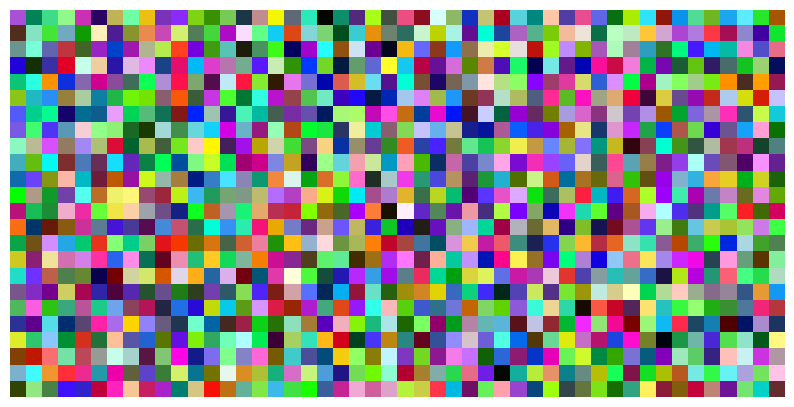

  0% 0/45000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch: 1 Loss: 1.8038: : 100% 45000/45000 [00:27<00:00, 1997.55it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch: 1 Loss: 1.8038: : 100% 45000/45000 [00:27<00:00, 1635.57it/s]
Eval Loss: 1.7612: : 100% 5000/5000 [00:08<00:00, 578.55it/s]
Train Epoch: 2 Loss: 1.2429: : 100% 45000/45000 [00:26<00:00, 1691.47it/s]
Eval Loss: 1.4990: : 100% 5000/5000 [00:08<00:00, 568.67it/s]
Train Epoch: 3 Loss: 1.1535: : 100% 45000/45000 [00:25<00:00, 1782.11it/s]
Eval Loss: 1.1606: : 100% 5000/5000 [00:08<00:00, 564.31it/s]
Train Epoch: 4 Loss: 1

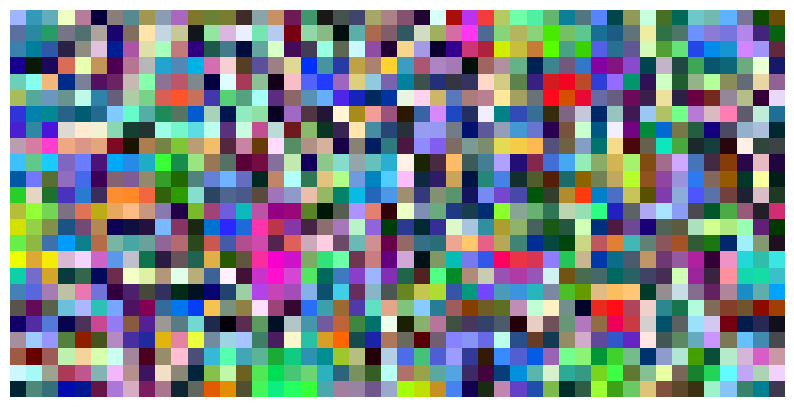

In [ ]:
trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()

In [ ]:
# Change this to the experiment you want to evaluate
path = '/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN/E10_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print(result)

Eval Loss: 0.8507: : 100% 10000/10000 [00:15<00:00, 641.98it/s]

{'loss': 0.8170739769935608, 'top1': 0.721, 'top5': 0.9780999999999997, 'accuracy': 72.1}


#### Wirte your report for Q1 in this cell.

The comparison between the filters before and after training shows some noticeable differences:

**Before Training:**

*   The filters appear very random, with no discernible patterns.
*   They contain a wide variety of colors and seem to be initialized without any specific structure.

**After Training:**



*   There are still many colors present, but some filters seem to exhibit more structure.
*   You can observe areas where certain colors dominate or where patterns begin to emerge, indicating that the filters have learned to identify specific features from the training data.

The differences suggest that the filters have adapted during the training process to capture meaningful patterns and features relevant to the data they were trained on. This adaptation is a key aspect of how convolutional neural networks learn to process and recognize patterns in images.

Training Accuracies without Batch Normalization:  [19.113333333333333, 39.275555555555556, 52.21333333333333, 60.24, 65.14222222222222, 69.63555555555556, 72.92888888888889, 74.49111111111111, 76.45555555555555, 77.69555555555556]
Validation Accuracies with Batch Normalization::  [30.26, 46.78, 59.12, 61.9, 64.9, 71.34, 73.16, 73.86, 75.34, 73.28]


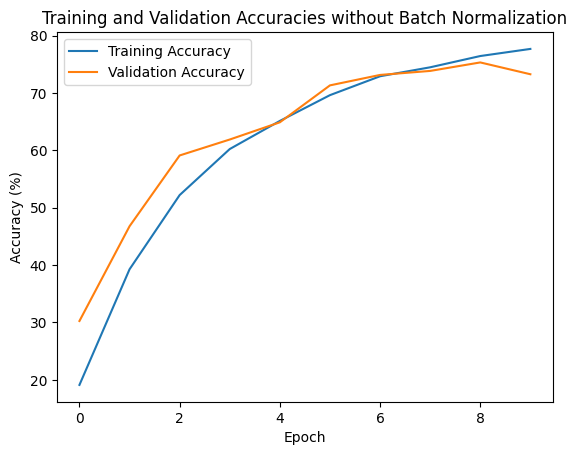

In [ ]:
# Print and plot accuracies
print("Training Accuracies without Batch Normalization: ", train_accuracies)
print("Validation Accuracies with Batch Normalization:: ", val_accuracies)

import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies without Batch Normalization')
plt.legend()
plt.show()

# Question 2: Improve training of Convolutional Networks (15 points)

## Part a

a) Batch normalization is a widely used operation in neural networks, which will increase the speed of convergence and reach higher performance. You can read the paper “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift” for more theoretical details.
In practice, these operations are implemented in most toolboxes, such as PyTorch and TensorFlow. Add batch normalization in the model of Q1.a (You can use PyTorch's implementation). Please keep other hyperparameters the same, but only add batch normalization. The ConvNet with batch normalization still uses the same class with Q1.a but different arguments. Check the code for details. In each block, the computations should be in the order of **[convolution -> batch normalization -> pooling -> ReLU]**. Compare the loss curves and accuracy using batch normalization to its counterpart in Q1.a. (5 points)

In order to run this experiment, please create a new config dictionary in `cnn_cifar10.py` under the name `q2a_normalization_experiment` (Hint: most of it should be similar to Q1's config). Don't forget to assign the config a new name, so that it doesn't overwrite previous experiments. Similar to the above cells, import the config and run the experiment.

You can also add extra code to `base_trainer.py` or `cnn_trainer.py` so that they return extra information after the training is finished. For example, recall that in assignment 2's `models/twolayernet/model.py` we had a train method that would return the history of loss values, and then in the notebook the history was plotted with matplotlib. Feel free to make adjustments that let you better understand what's happening. This also applies to next questions. Right now the code only uses tensorboard and wandb for plotting (if enabled in config).

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q2a_config = cnn_cifar10.q2a_normalization_experiment

In [ ]:
# Initialize data loaders
datamodule_class = q2a_config['datamodule']
data_args = q2a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_BatchNorm.log already exists! The logs will be appended!


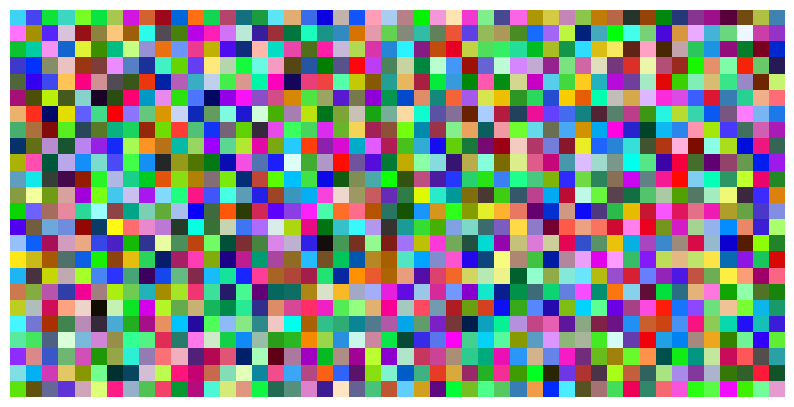

Train Epoch: 1 Loss: 1.3640: : 100% 45000/45000 [00:30<00:00, 1491.57it/s]
Eval Loss: 1.3073: : 100% 5000/5000 [00:07<00:00, 686.88it/s]
Train Epoch: 2 Loss: 0.9477: : 100% 45000/45000 [00:31<00:00, 1419.36it/s]
Eval Loss: 1.3611: : 100% 5000/5000 [00:06<00:00, 714.43it/s]
Train Epoch: 3 Loss: 0.7802: : 100% 45000/45000 [00:30<00:00, 1496.68it/s]
Eval Loss: 1.2769: : 100% 5000/5000 [00:07<00:00, 671.45it/s]
Train Epoch: 4 Loss: 0.7143: : 100% 45000/45000 [00:29<00:00, 1507.48it/s]
Eval Loss: 0.9774: : 100% 5000/5000 [00:08<00:00, 563.80it/s]
Train Epoch: 5 Loss: 0.6673: : 100% 45000/45000 [00:29<00:00, 1507.93it/s]
Eval Loss: 1.1275: : 100% 5000/5000 [00:09<00:00, 515.32it/s]
Train Epoch: 6 Loss: 0.4834: : 100% 45000/45000 [00:29<00:00, 1516.60it/s]
Eval Loss: 0.8329: : 100% 5000/5000 [00:07<00:00, 696.80it/s]
Train Epoch: 7 Loss: 0.4585: : 100% 45000/45000 [00:29<00:00, 1504.31it/s]
Eval Loss: 0.5361: : 100% 5000/5000 [00:06<00:00, 741.78it/s]
Train Epoch: 8 Loss: 0.5038: : 100% 45000

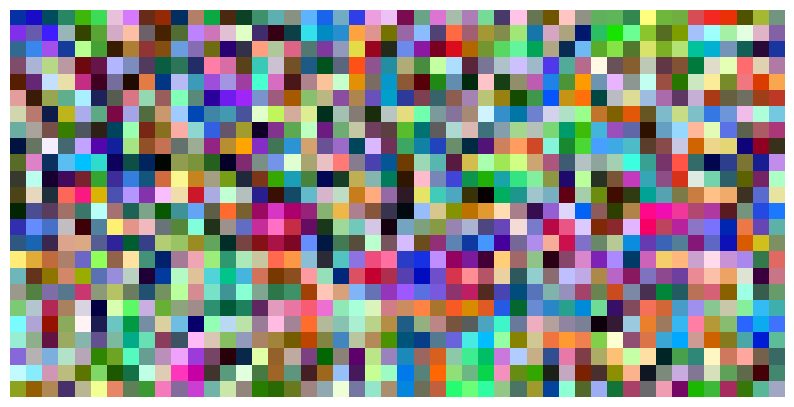

In [ ]:
# Initialize trainer
trainer_class = q2a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q2a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()

Training Accuracies with Batch Normalization :  [40.7, 61.72, 68.2088888888889, 72.63333333333334, 76.1511111111111, 80.71777777777778, 82.64, 84.22444444444444, 86.2688888888889, 87.44]
Validation Accuracies with Batch Normalization:  [49.98, 50.9, 57.4, 65.64, 61.24, 71.68, 79.2, 76.58, 78.72, 77.96]


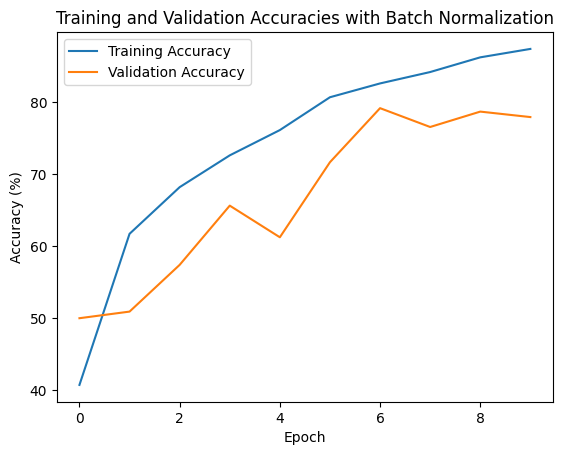

In [ ]:
# Print and plot accuracies
print("Training Accuracies with Batch Normalization : ", train_accuracies)
print("Validation Accuracies with Batch Normalization: ", val_accuracies)

import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies with Batch Normalization')
plt.legend()
plt.show()

Wirte your report for Q2.a in this cell. Feel free to add extra code cells

**Training and Validation Accuracy with Batch Normalization**



*   Training Accuracy:
    * Increases steadily from 40.7% to 87.4% over 10 epochs.
    * Shows a consistent and gradual improvement without significant drops.
*   Validation Accuracy:
    * Starts at 49.98% and improves to 77.96% over 10 epochs.
    * Demonstrates a more stable and higher accuracy compared to the model without Batch Normalization.

**Training and Validation Accuracy without Batch Normalization**



*   Training Accuracy:
    * Starts at 19.11% and reaches 77.69% over 10 epochs.
    * Also shows a steady increase but the final accuracy is slightly lower compared to the model with Batch Normalization.
*   Validation Accuracy:
    * Starts at 30.26% and improves to 73.28% over 10 epochs.
    * Shows a higher initial jump but then stabilizes and does not increase as much as the model with Batch Normalization.


**CONCULSION**
The model with Batch Normalization consistently outperforms the model without it in terms of both training and validation accuracy. It shows smoother and more stable learning curves, achieving higher final accuracies. This demonstrates the effectiveness of Batch Normalization in training deep neural networks, providing better generalization and higher overall performance.


## Part b

b) Throughout training, we optimize our parameters on the training set. This does not guarantee that with every step we also improve on validation and test set as well! Hence, there is no reason for our latest training checkpoint (the last checkpoint after the last epoch) to be the best to keep. One simple idea is to save a checkpoint of the best model for the validation set throughout the training. Meanining that as the training proceeds, we keep checking our **validation** accuracy after each epoch (or every N epochs) and save the best model. This can mitigate overfitting, as if the model overfits to training data (and accuracy on validation set drops), we would still have access to the best model checkpoint! Note that you **should not** do this on the test set, as we are not alowed to optimize **anything** (including the checkpoint selection) on the test set.

For this task, you need add the logic for saving the `best model` during the training. In the `src/trainers/base_trainer`, in method `train()` we already have the call to `self.evaluate()`. All you need to add is to process the returned result (a dictionary of metric_key -> metric_value) and see if you should save a checkpoint of the model. If yes, then you can save a checkpoint at `self.checkpoint_dir` under `best_val_model.pth` or a similar name, using the `save_model()` method. Feel free to define additional class attributes or methods if needed.

We also recommend adding a few prints, such as the epochs that you save the best model at. You can also use the `self.logger` object.

Please also implement the `should_evaluate()` in the `trainers/base_tariner.py`, which allows for doing the cross-validation evaluation in intervals, based on the config.


Increase the training epochs to 50 in Q1.a and Q2.a (simply edit their config dictionaries), and compare the **best model** and **latest model** on the **training set** and **validation set**. Due to the randomness, you can train multiple times to verify and observe overfitting and early stopping. (5 points)


Feel free to add any needed train/evaluation code below for this task.

### q1 on 50 epochs, with record of best model

In [6]:
from cfgs.exercise_3 import cnn_cifar10

q1_config = cnn_cifar10.q1_experiment

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


In [ ]:
trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()

Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN already exists!Existing checkpoints will be overwritten!


  0% 0/45000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch: 1 Loss: 1.5857: : 100% 45000/45000 [00:27<00:00, 1629.74it/s]
Eval Loss: 1.5952: : 100% 5000/5000 [00:06<00:00, 762.94it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.0452: : 100% 45000/45000 [00:25<00:00, 1754.77it/s]
Eval Loss: 1.2011: : 100% 5000/5000 [00:08<00:00, 614.61it/s]


New best at epoch 2


Train Epoch: 3 Loss: 1.1283: : 100% 45000/45000 [00:25<00:00, 1777.08it/s]
Eval Loss: 1.0410: : 100% 5000/5000 [00:08<00:00, 606.06it/s]


New best at epoch 3


Train Epoch: 4 Loss: 0.8205: : 100% 45000/45000 [00:25<00:00, 1797.02it/s]
Eval Loss: 0.8915: : 100% 5000/5000 [00:08<00:00, 596.02it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.8975: : 100% 45000/45000 [00:25<00:00, 1792.73it/s]
Eval Loss: 0.8383: : 100% 5000/5000 [00:08<00:00, 573.70it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.6674: : 100% 45000/45000 [00:26<00:00, 1709.15it/s]
Eval Loss: 0.7597: : 100% 5000/5000 [00:07<00:00, 634.66it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.6148: : 100% 45000/45000 [00:25<00:00, 1760.03it/s]
Eval Loss: 0.6754: : 100% 5000/5000 [00:08<00:00, 600.36it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.5146: : 100% 45000/45000 [00:25<00:00, 1783.27it/s]
Eval Loss: 0.6751: : 100% 5000/5000 [00:08<00:00, 587.36it/s]
Train Epoch: 9 Loss: 0.7207: : 100% 45000/45000 [00:25<00:00, 1780.61it/s]
Eval Loss: 0.6562: : 100% 5000/5000 [00:08<00:00, 579.52it/s]
Train Epoch: 10 Loss: 0.5712: : 100% 45000/45000 [00:24<00:00, 1807.08it/s]
Eval Loss: 0.6593: : 100% 5000/5000 [00:08<00:00, 588.13it/s]


New best at epoch 10


Train Epoch: 11 Loss: 0.5006: : 100% 45000/45000 [00:26<00:00, 1727.71it/s]
Eval Loss: 0.5934: : 100% 5000/5000 [00:08<00:00, 588.45it/s]


New best at epoch 11


Train Epoch: 12 Loss: 0.4245: : 100% 45000/45000 [00:25<00:00, 1777.89it/s]
Eval Loss: 0.6048: : 100% 5000/5000 [00:08<00:00, 614.23it/s]


New best at epoch 12


Train Epoch: 13 Loss: 0.4313: : 100% 45000/45000 [00:25<00:00, 1771.73it/s]
Eval Loss: 0.5936: : 100% 5000/5000 [00:07<00:00, 645.79it/s]
Train Epoch: 14 Loss: 0.3450: : 100% 45000/45000 [00:25<00:00, 1766.08it/s]
Eval Loss: 0.5839: : 100% 5000/5000 [00:07<00:00, 631.01it/s]
Train Epoch: 15 Loss: 0.3742: : 100% 45000/45000 [00:25<00:00, 1783.51it/s]
Eval Loss: 0.7278: : 100% 5000/5000 [00:07<00:00, 632.86it/s]
Train Epoch: 16 Loss: 0.2486: : 100% 45000/45000 [00:25<00:00, 1759.80it/s]
Eval Loss: 0.6553: : 100% 5000/5000 [00:08<00:00, 613.97it/s]


New best at epoch 16


Train Epoch: 17 Loss: 0.2070: : 100% 45000/45000 [00:26<00:00, 1715.90it/s]
Eval Loss: 0.7327: : 100% 5000/5000 [00:08<00:00, 573.07it/s]
Train Epoch: 18 Loss: 0.2007: : 100% 45000/45000 [00:25<00:00, 1787.66it/s]
Eval Loss: 0.7814: : 100% 5000/5000 [00:08<00:00, 592.15it/s]
Train Epoch: 19 Loss: 0.1918: : 100% 45000/45000 [00:25<00:00, 1788.84it/s]
Eval Loss: 0.7114: : 100% 5000/5000 [00:08<00:00, 598.18it/s]
Train Epoch: 20 Loss: 0.1942: : 100% 45000/45000 [00:25<00:00, 1776.27it/s]
Eval Loss: 0.7948: : 100% 5000/5000 [00:08<00:00, 606.84it/s]
Train Epoch: 21 Loss: 0.1356: : 100% 45000/45000 [00:25<00:00, 1769.98it/s]
Eval Loss: 0.8032: : 100% 5000/5000 [00:07<00:00, 668.59it/s]
Train Epoch: 22 Loss: 0.1211: : 100% 45000/45000 [00:25<00:00, 1736.52it/s]
Eval Loss: 0.7602: : 100% 5000/5000 [00:08<00:00, 578.00it/s]
Train Epoch: 23 Loss: 0.0547: : 100% 45000/45000 [00:25<00:00, 1794.99it/s]
Eval Loss: 0.7928: : 100% 5000/5000 [00:08<00:00, 601.73it/s]
Train Epoch: 24 Loss: 0.1298: : 10

New best at epoch 28


Train Epoch: 29 Loss: 0.0236: : 100% 45000/45000 [00:25<00:00, 1793.87it/s]
Eval Loss: 0.9794: : 100% 5000/5000 [00:08<00:00, 609.47it/s]


New best at epoch 29


Train Epoch: 30 Loss: 0.0247: : 100% 45000/45000 [00:25<00:00, 1796.98it/s]
Eval Loss: 0.9786: : 100% 5000/5000 [00:08<00:00, 617.57it/s]
Train Epoch: 31 Loss: 0.0198: : 100% 45000/45000 [00:25<00:00, 1766.66it/s]
Eval Loss: 0.9377: : 100% 5000/5000 [00:07<00:00, 663.21it/s]
Train Epoch: 32 Loss: 0.0283: : 100% 45000/45000 [00:25<00:00, 1771.19it/s]
Eval Loss: 0.9274: : 100% 5000/5000 [00:07<00:00, 646.05it/s]
Train Epoch: 33 Loss: 0.0152: : 100% 45000/45000 [00:25<00:00, 1787.62it/s]
Eval Loss: 0.9395: : 100% 5000/5000 [00:09<00:00, 507.82it/s]
Train Epoch: 34 Loss: 0.0243: : 100% 45000/45000 [00:25<00:00, 1789.60it/s]
Eval Loss: 0.9296: : 100% 5000/5000 [00:07<00:00, 643.64it/s]


New best at epoch 34


Train Epoch: 35 Loss: 0.0167: : 100% 45000/45000 [00:25<00:00, 1773.35it/s]
Eval Loss: 0.9692: : 100% 5000/5000 [00:07<00:00, 643.33it/s]
Train Epoch: 36 Loss: 0.0133: : 100% 45000/45000 [00:25<00:00, 1779.62it/s]
Eval Loss: 0.9280: : 100% 5000/5000 [00:07<00:00, 649.61it/s]
Train Epoch: 37 Loss: 0.0150: : 100% 45000/45000 [00:25<00:00, 1791.77it/s]
Eval Loss: 0.9650: : 100% 5000/5000 [00:07<00:00, 649.26it/s]
Train Epoch: 38 Loss: 0.0142: : 100% 45000/45000 [00:25<00:00, 1785.24it/s]
Eval Loss: 0.9750: : 100% 5000/5000 [00:07<00:00, 638.41it/s]
Train Epoch: 39 Loss: 0.0211: : 100% 45000/45000 [00:26<00:00, 1706.74it/s]
Eval Loss: 0.9673: : 100% 5000/5000 [00:07<00:00, 654.73it/s]
Train Epoch: 40 Loss: 0.0172: : 100% 45000/45000 [00:25<00:00, 1771.57it/s]
Eval Loss: 0.9840: : 100% 5000/5000 [00:07<00:00, 653.13it/s]
Train Epoch: 41 Loss: 0.0174: : 100% 45000/45000 [00:25<00:00, 1754.25it/s]
Eval Loss: 0.9784: : 100% 5000/5000 [00:06<00:00, 762.92it/s]
Train Epoch: 42 Loss: 0.0159: : 10

In [8]:
last_models = []
best_models = []

# Change this to the experiment you want to evaluate
path = '/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN/last_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print('Results from last model:')
print(result)
print()
last_models.append(result['accuracy'])

monitor_mode, monitor_metric = q1_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('Results from best model:')
print(result)
print()
best_models.append(result['accuracy'])


  0% 0/10000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Eval Loss: 1.2606: : 100% 10000/10000 [00:12<00:00, 783.82it/s]


Results from last model:
{'loss': 1.1424181354045868, 'top1': 0.7676000000000003, 'top5': 0.9791000000000001, 'accuracy': 76.76}



Eval Loss: 1.1214: : 100% 10000/10000 [00:10<00:00, 946.65it/s]


Results from best model:
{'loss': 1.090877515077591, 'top1': 0.7727999999999997, 'top5': 0.9793, 'accuracy': 77.28}



### q2a on 50 epochs, with record of best model

In [9]:
from cfgs.exercise_3 import cnn_cifar10
q2a_config = cnn_cifar10.q2a_normalization_experiment

In [10]:
# Initialize data loaders
datamodule_class = q2a_config['datamodule']
data_args = q2a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


In [ ]:
# Initialize trainer
trainer_class = q2a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q2a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()

Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_BatchNorm.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_BatchNorm already exists!Existing checkpoints will be overwritten!


Train Epoch: 1 Loss: 1.0819: : 100% 45000/45000 [00:29<00:00, 1534.97it/s]
Eval Loss: 1.2780: : 100% 5000/5000 [00:07<00:00, 678.71it/s]


New best at epoch 1


Train Epoch: 2 Loss: 0.8903: : 100% 45000/45000 [00:32<00:00, 1393.84it/s]
Eval Loss: 1.1638: : 100% 5000/5000 [00:07<00:00, 678.90it/s]


New best at epoch 2


Train Epoch: 3 Loss: 0.9641: : 100% 45000/45000 [00:32<00:00, 1389.66it/s]
Eval Loss: 1.7720: : 100% 5000/5000 [00:09<00:00, 550.50it/s]
Train Epoch: 4 Loss: 0.7282: : 100% 45000/45000 [00:32<00:00, 1380.90it/s]
Eval Loss: 0.9481: : 100% 5000/5000 [00:06<00:00, 786.66it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.6689: : 100% 45000/45000 [00:29<00:00, 1504.99it/s]
Eval Loss: 0.7921: : 100% 5000/5000 [00:06<00:00, 725.77it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.6822: : 100% 45000/45000 [00:29<00:00, 1520.35it/s]
Eval Loss: 0.8545: : 100% 5000/5000 [00:08<00:00, 586.01it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.6769: : 100% 45000/45000 [00:29<00:00, 1522.97it/s]
Eval Loss: 0.5963: : 100% 5000/5000 [00:06<00:00, 775.77it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.5996: : 100% 45000/45000 [00:30<00:00, 1498.80it/s]
Eval Loss: 0.6014: : 100% 5000/5000 [00:06<00:00, 787.98it/s]


New best at epoch 8


Train Epoch: 9 Loss: 0.4875: : 100% 45000/45000 [00:29<00:00, 1534.46it/s]
Eval Loss: 0.5658: : 100% 5000/5000 [00:06<00:00, 735.22it/s]


New best at epoch 9


Train Epoch: 10 Loss: 0.4758: : 100% 45000/45000 [00:29<00:00, 1537.75it/s]
Eval Loss: 0.5564: : 100% 5000/5000 [00:08<00:00, 615.11it/s]
Train Epoch: 11 Loss: 0.2872: : 100% 45000/45000 [00:28<00:00, 1576.40it/s]
Eval Loss: 0.5536: : 100% 5000/5000 [00:07<00:00, 637.84it/s]


New best at epoch 11


Train Epoch: 12 Loss: 0.2448: : 100% 45000/45000 [00:28<00:00, 1568.25it/s]
Eval Loss: 0.5412: : 100% 5000/5000 [00:06<00:00, 766.01it/s]
Train Epoch: 13 Loss: 0.2726: : 100% 45000/45000 [00:29<00:00, 1543.94it/s]
Eval Loss: 0.6960: : 100% 5000/5000 [00:06<00:00, 759.27it/s]
Train Epoch: 14 Loss: 0.2870: : 100% 45000/45000 [00:28<00:00, 1564.68it/s]
Eval Loss: 0.7874: : 100% 5000/5000 [00:06<00:00, 776.77it/s]
Train Epoch: 15 Loss: 0.1923: : 100% 45000/45000 [00:28<00:00, 1572.53it/s]
Eval Loss: 0.6243: : 100% 5000/5000 [00:06<00:00, 786.91it/s]
Train Epoch: 16 Loss: 0.1391: : 100% 45000/45000 [00:28<00:00, 1577.44it/s]
Eval Loss: 0.6658: : 100% 5000/5000 [00:06<00:00, 780.71it/s]
Train Epoch: 17 Loss: 0.1899: : 100% 45000/45000 [00:28<00:00, 1556.29it/s]
Eval Loss: 0.8604: : 100% 5000/5000 [00:06<00:00, 733.56it/s]
Train Epoch: 18 Loss: 0.1585: : 100% 45000/45000 [00:28<00:00, 1556.41it/s]
Eval Loss: 0.6725: : 100% 5000/5000 [00:09<00:00, 530.00it/s]
Train Epoch: 19 Loss: 0.1344: : 10

New best at epoch 21


Train Epoch: 22 Loss: 0.0297: : 100% 45000/45000 [00:28<00:00, 1578.74it/s]
Eval Loss: 0.6906: : 100% 5000/5000 [00:06<00:00, 771.54it/s]


New best at epoch 22


Train Epoch: 23 Loss: 0.0419: : 100% 45000/45000 [00:28<00:00, 1580.97it/s]
Eval Loss: 0.8214: : 100% 5000/5000 [00:07<00:00, 665.12it/s]
Train Epoch: 24 Loss: 0.1152: : 100% 45000/45000 [00:29<00:00, 1540.20it/s]
Eval Loss: 0.6851: : 100% 5000/5000 [00:07<00:00, 625.31it/s]
Train Epoch: 25 Loss: 0.1511: : 100% 45000/45000 [00:27<00:00, 1616.70it/s]
Eval Loss: 0.7668: : 100% 5000/5000 [00:07<00:00, 649.38it/s]
Train Epoch: 26 Loss: 0.0717: : 100% 45000/45000 [00:28<00:00, 1590.91it/s]
Eval Loss: 0.6089: : 100% 5000/5000 [00:06<00:00, 761.45it/s]
Train Epoch: 27 Loss: 0.0315: : 100% 45000/45000 [00:28<00:00, 1574.17it/s]
Eval Loss: 0.6730: : 100% 5000/5000 [00:06<00:00, 762.24it/s]
Train Epoch: 28 Loss: 0.0056: : 100% 45000/45000 [00:28<00:00, 1585.87it/s]
Eval Loss: 0.7295: : 100% 5000/5000 [00:06<00:00, 781.96it/s]


New best at epoch 28


Train Epoch: 29 Loss: 0.0115: : 100% 45000/45000 [00:29<00:00, 1545.37it/s]
Eval Loss: 0.7062: : 100% 5000/5000 [00:06<00:00, 767.77it/s]


New best at epoch 29


Train Epoch: 30 Loss: 0.0037: : 100% 45000/45000 [00:28<00:00, 1584.54it/s]
Eval Loss: 0.6629: : 100% 5000/5000 [00:07<00:00, 703.88it/s]
Train Epoch: 31 Loss: 0.0022: : 100% 45000/45000 [00:28<00:00, 1585.96it/s]
Eval Loss: 0.6477: : 100% 5000/5000 [00:08<00:00, 609.25it/s]


New best at epoch 31


Train Epoch: 32 Loss: 0.0032: : 100% 45000/45000 [00:27<00:00, 1609.34it/s]
Eval Loss: 0.6215: : 100% 5000/5000 [00:07<00:00, 653.23it/s]


New best at epoch 32


Train Epoch: 33 Loss: 0.0024: : 100% 45000/45000 [00:28<00:00, 1587.78it/s]
Eval Loss: 0.6274: : 100% 5000/5000 [00:06<00:00, 765.68it/s]
Train Epoch: 34 Loss: 0.0027: : 100% 45000/45000 [00:28<00:00, 1574.04it/s]
Eval Loss: 0.6102: : 100% 5000/5000 [00:07<00:00, 657.21it/s]
Train Epoch: 35 Loss: 0.0033: : 100% 45000/45000 [00:28<00:00, 1578.72it/s]
Eval Loss: 0.6086: : 100% 5000/5000 [00:06<00:00, 797.94it/s]
Train Epoch: 36 Loss: 0.0039: : 100% 45000/45000 [00:28<00:00, 1589.01it/s]
Eval Loss: 0.6073: : 100% 5000/5000 [00:06<00:00, 798.63it/s]
Train Epoch: 37 Loss: 0.0029: : 100% 45000/45000 [00:28<00:00, 1582.66it/s]
Eval Loss: 0.5930: : 100% 5000/5000 [00:06<00:00, 795.33it/s]
Train Epoch: 38 Loss: 0.0043: : 100% 45000/45000 [00:28<00:00, 1580.25it/s]
Eval Loss: 0.5819: : 100% 5000/5000 [00:06<00:00, 751.13it/s]
Train Epoch: 39 Loss: 0.0028: : 100% 45000/45000 [00:28<00:00, 1569.67it/s]
Eval Loss: 0.5881: : 100% 5000/5000 [00:07<00:00, 638.27it/s]
Train Epoch: 40 Loss: 0.0021: : 10

In [12]:
# Change this to the experiment you want to evaluate
path = '/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_BatchNorm/last_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print('Results from last model:')
print(result)
print()
last_models.append(result['accuracy'])

monitor_mode, monitor_metric = q2a_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_BatchNorm/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print(f'Results from best {monitor_metric} model:')
print(result)
print()
best_models.append(result['accuracy'])


  0% 0/10000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Eval Loss: 0.6197: : 100% 10000/10000 [00:10<00:00, 968.13it/s]


Results from last model:
{'loss': 0.7103208678960801, 'top1': 0.8166, 'top5': 0.9812000000000001, 'accuracy': 81.66}



Eval Loss: 0.6403: : 100% 10000/10000 [00:10<00:00, 965.95it/s]


Results from best eval_accuracy model:
{'loss': 0.7179053938388824, 'top1': 0.8242, 'top5': 0.9845999999999997, 'accuracy': 82.42}



### Q2.b report

q1 on 50 epochs:
<br>
Last model accuracy: 76.76
<br>
Best model accuracy: 77.28
<br>
<br>
q2a on 50 epochs:
<br>
Last model accuracy: 81.66
<br>
Best model accuracy: 82.42
<br>
<br>
As we can clearly see from these figures, we are able to achieve the best model earlier than 50 epochs, telling us that it's not a good idea to train for the entire number, rather just save the best model.


## Part c

c) While in part `b` we save the best model, we still do as many epochs as indicated in the config file. This is not convenient as the overfitting steps are wasting time and compute and also wouldn't affect the best model. Hence, Early Stopping can be helpful, where we **stop** the training after a few non-improving steps! Early stopping logic should be considered after every training epoch is finished, to see if we should do more epochs or not. Therefore, the logic should should be implemented ath the end of the loop over epochs in the `train()` method of `base_trainer.py` (which takes care of running multiple epochs).

Once implemented, you need a new config dictionary to enable early stopping. Simply create a new one at the bottom of `cfgs/exercise-3/cnn_cifar10.py`. It should be mostly similar to previous config, with the following modification:
```Python
q2c_earlystop_experiment = dict(
    name = 'Some New Name' # Otherwise it will overwrite previous experiment!
    ...
    trainer = dict(
        ...
        monitor = "off", # -> chante to "max eval_top1"
        early_stop = 0, #  -> change to 4
    ),
)
```
This will enable the early stopping to be considered for `eval_top1` metric and the maximum number of non-improving steps will be set to 4.

Use the cells below to re-run one of the experiments from part `b` that the best epoch was way lower than the total number of epochs, and see if early stopping can prevent unnecessary training epochs in that case.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q2c_config = cnn_cifar10.q2c_earlystop_experiment

In [ ]:
# Initialize data loaders
datamodule_class = q2c_config['datamodule']
data_args = q2c_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


In [ ]:
# Initialize trainer
trainer_class = q2c_config['trainer_module']
trainer_cnn = trainer_class(
    config=q2c_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()

Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_EarlyStop.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_EarlyStop already exists!Existing checkpoints will be overwritten!


Train Epoch: 1 Loss: 1.0282: : 100% 45000/45000 [00:29<00:00, 1544.53it/s]
Eval Loss: 1.2887: : 100% 5000/5000 [00:08<00:00, 612.39it/s]


New best at epoch 1


Train Epoch: 2 Loss: 0.9053: : 100% 45000/45000 [00:29<00:00, 1535.41it/s]
Eval Loss: 1.0874: : 100% 5000/5000 [00:07<00:00, 650.69it/s]


New best at epoch 2


Train Epoch: 3 Loss: 0.7334: : 100% 45000/45000 [00:29<00:00, 1526.31it/s]
Eval Loss: 1.3701: : 100% 5000/5000 [00:06<00:00, 763.15it/s]
Train Epoch: 4 Loss: 0.5720: : 100% 45000/45000 [00:30<00:00, 1462.57it/s]
Eval Loss: 0.9307: : 100% 5000/5000 [00:06<00:00, 783.97it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.6998: : 100% 45000/45000 [00:30<00:00, 1482.59it/s]
Eval Loss: 1.0389: : 100% 5000/5000 [00:06<00:00, 772.84it/s]
Train Epoch: 6 Loss: 0.7209: : 100% 45000/45000 [00:29<00:00, 1545.90it/s]
Eval Loss: 0.6611: : 100% 5000/5000 [00:06<00:00, 762.89it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.5010: : 100% 45000/45000 [00:29<00:00, 1546.27it/s]
Eval Loss: 0.5267: : 100% 5000/5000 [00:07<00:00, 677.59it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.4508: : 100% 45000/45000 [00:28<00:00, 1568.01it/s]
Eval Loss: 0.6669: : 100% 5000/5000 [00:07<00:00, 626.71it/s]
Train Epoch: 9 Loss: 0.3969: : 100% 45000/45000 [00:28<00:00, 1571.79it/s]
Eval Loss: 0.6000: : 100% 5000/5000 [00:06<00:00, 764.00it/s]
Train Epoch: 10 Loss: 0.3028: : 100% 45000/45000 [00:29<00:00, 1522.07it/s]
Eval Loss: 0.4550: : 100% 5000/5000 [00:06<00:00, 773.35it/s]


New best at epoch 10


Train Epoch: 11 Loss: 0.3143: : 100% 45000/45000 [00:28<00:00, 1561.52it/s]
Eval Loss: 0.5829: : 100% 5000/5000 [00:07<00:00, 629.93it/s]
Train Epoch: 12 Loss: 0.2277: : 100% 45000/45000 [00:28<00:00, 1592.34it/s]
Eval Loss: 0.6830: : 100% 5000/5000 [00:07<00:00, 630.42it/s]
Train Epoch: 13 Loss: 0.2749: : 100% 45000/45000 [00:28<00:00, 1582.98it/s]
Eval Loss: 0.6527: : 100% 5000/5000 [00:06<00:00, 751.48it/s]
Train Epoch: 14 Loss: 0.3057: : 100% 45000/45000 [00:28<00:00, 1572.79it/s]
Eval Loss: 0.6106: : 100% 5000/5000 [00:06<00:00, 784.85it/s]
Train Epoch: 15 Loss: 0.2859: : 100% 45000/45000 [00:28<00:00, 1559.41it/s]
Eval Loss: 0.6080: : 100% 5000/5000 [00:07<00:00, 705.72it/s]


New best at epoch 15


Train Epoch: 16 Loss: 0.1749: : 100% 45000/45000 [00:28<00:00, 1560.88it/s]
Eval Loss: 0.8079: : 100% 5000/5000 [00:06<00:00, 788.65it/s]
Train Epoch: 17 Loss: 0.1114: : 100% 45000/45000 [00:28<00:00, 1568.86it/s]
Eval Loss: 0.7024: : 100% 5000/5000 [00:06<00:00, 791.84it/s]
Train Epoch: 18 Loss: 0.1968: : 100% 45000/45000 [00:28<00:00, 1582.73it/s]
Eval Loss: 0.6565: : 100% 5000/5000 [00:06<00:00, 735.05it/s]
Train Epoch: 19 Loss: 0.2211: : 100% 45000/45000 [00:28<00:00, 1557.13it/s]
Eval Loss: 0.7435: : 100% 5000/5000 [00:07<00:00, 640.46it/s]


New best at epoch 19


Train Epoch: 20 Loss: 0.1543: : 100% 45000/45000 [00:28<00:00, 1595.10it/s]
Eval Loss: 0.7043: : 100% 5000/5000 [00:07<00:00, 625.83it/s]
Train Epoch: 21 Loss: 0.0682: : 100% 45000/45000 [00:29<00:00, 1542.36it/s]
Eval Loss: 0.7167: : 100% 5000/5000 [00:06<00:00, 752.53it/s]


New best at epoch 21


Train Epoch: 22 Loss: 0.0503: : 100% 45000/45000 [00:28<00:00, 1574.86it/s]
Eval Loss: 0.6751: : 100% 5000/5000 [00:06<00:00, 783.77it/s]
Train Epoch: 23 Loss: 0.0454: : 100% 45000/45000 [00:28<00:00, 1562.78it/s]
Eval Loss: 0.7850: : 100% 5000/5000 [00:06<00:00, 786.29it/s]
Train Epoch: 24 Loss: 0.1564: : 100% 45000/45000 [00:28<00:00, 1575.67it/s]
Eval Loss: 0.8178: : 100% 5000/5000 [00:06<00:00, 785.46it/s]
Train Epoch: 25 Loss: 0.0704: : 100% 45000/45000 [00:28<00:00, 1575.00it/s]
Eval Loss: 0.7723: : 100% 5000/5000 [00:06<00:00, 755.32it/s]
Train Epoch: 26 Loss: 0.0373: : 100% 45000/45000 [00:29<00:00, 1530.29it/s]
Eval Loss: 0.6866: : 100% 5000/5000 [00:08<00:00, 622.69it/s]


New best at epoch 26


Train Epoch: 27 Loss: 0.0267: : 100% 45000/45000 [00:27<00:00, 1613.83it/s]
Eval Loss: 0.6576: : 100% 5000/5000 [00:07<00:00, 627.03it/s]


New best at epoch 27


Train Epoch: 28 Loss: 0.0211: : 100% 45000/45000 [00:28<00:00, 1585.13it/s]
Eval Loss: 0.6648: : 100% 5000/5000 [00:06<00:00, 778.12it/s]
Train Epoch: 29 Loss: 0.0114: : 100% 45000/45000 [00:28<00:00, 1587.23it/s]
Eval Loss: 0.6560: : 100% 5000/5000 [00:06<00:00, 799.95it/s]


New best at epoch 29


Train Epoch: 30 Loss: 0.0071: : 100% 45000/45000 [00:28<00:00, 1577.50it/s]
Eval Loss: 0.6290: : 100% 5000/5000 [00:06<00:00, 790.83it/s]


New best at epoch 30


Train Epoch: 31 Loss: 0.0018: : 100% 45000/45000 [00:28<00:00, 1573.51it/s]
Eval Loss: 0.6230: : 100% 5000/5000 [00:06<00:00, 741.92it/s]
Train Epoch: 32 Loss: 0.0029: : 100% 45000/45000 [00:29<00:00, 1530.37it/s]
Eval Loss: 0.6190: : 100% 5000/5000 [00:06<00:00, 767.22it/s]
Train Epoch: 33 Loss: 0.0028: : 100% 45000/45000 [00:28<00:00, 1577.71it/s]
Eval Loss: 0.6336: : 100% 5000/5000 [00:06<00:00, 782.96it/s]
Train Epoch: 34 Loss: 0.0023: : 100% 45000/45000 [00:28<00:00, 1579.52it/s]
Eval Loss: 0.6049: : 100% 5000/5000 [00:06<00:00, 753.34it/s]
Train Epoch: 35 Loss: 0.0024: : 100% 45000/45000 [00:28<00:00, 1571.54it/s]
Eval Loss: 0.6121: : 100% 5000/5000 [00:07<00:00, 656.05it/s]


Early stopping point reached at epoch 35


In [ ]:

monitor_mode, monitor_metric = q2c_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_EarlyStop/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('Repeated experiment q2a but with early stopping.')
print(f'Results from best {monitor_metric} model:')
print(result)
print()


Eval Loss: 0.9921: : 100% 10000/10000 [00:14<00:00, 679.50it/s]


Repeated experiment q2a but with early stopping.
Results from best eval_accuracy model:
{'loss': 0.7730340534448623, 'top1': 0.8168999999999998, 'top5': 0.9838999999999996, 'accuracy': 81.69}



###Q2.c report


q2a on 50 epochs:
<br>
Best model accuracy: 82.42

q2a on 50 epochs, but with early stopping (at epoch 35):
<br>
Best model accuracy: 81.69

As we can see from the above figures, we are able to get a model with very comparable accuracy to the best possible method if we had not employed early stopping to begin with.

As the fugures show, it's also possible to get a higher accuracy if we train further, but the gain in accuracy does not justify the increased computation cost.

# Question 3: Improve generalization of Convolutional Networks (10 points)

We saw in Q2 that the model can start over-fitting to the training set if we continue training for long. To prevent over-fitting, there are two main paradigms we can focus on.

The first is to get more training data. This might be a difficult and expensive process. However, it is generally the most effective way to learn more general models. A cheaper alternative is to perform data augmentation. The second approach is to regularize the model to prevent overfitting.

In the following sub-questions, we will experiment with each of these paradigms and measure the effect on the model generalization. We recommend disabling Early Stopping from previous question (simply removing it from config file) so that it does not interrupt your experiments with data augmentations and you maintain full control over number of epochs.



a) Data augmentation is the process of creating more training data by applying certain transformations to the training set images. Usually, the underlying assumption is that the label of the image does not change under the applied transformations. This includes geometric transformations like translation, rotation, scaling, flipping, random cropping, and color transformations like greyscale, colorjitter. For every image in the training batch, a random transformation is sampled from the possible ones (e.g., a random number of pixels to translate the image by) and is applied to the image. While designing the data input pipeline, we must choose the hyper-parameters for these transformations (e.g., limits of translation or rotation) based on things we expect to see in the test-set/real world. Your task in this question is to implement the data augmentation for the CIFAR-10 classification task. Many of these transformations are implemented in the `torchvision.transforms` package. Familiarize yourself with the APIs of these transforms, and functions to compose multiple transforms or randomly sample them. Next, implement geometric and color space data augmentations for the CIFAR-10 dataset, by choosing the right functions and order of application. Tune the hyper-parameters of these data augmentations to improve the validation performance. You will need to train the model a bit longer (20-30 epochs) with data augmentation, as the training data is effectively larger now. Discuss which augmentations work well for you in the report. (6 points)

Create as many config dictionaries as you need in `cnn_cifar10.py`. For every augmentation, simply create a new preset under `src/utils/transform_presets.py` and reference its name in your experiment's config dict.



b) Dropout is a popular scheme to regularize the model to improve generalization. The dropout layer works by setting the input activations randomly to zero at the output. You can implement Dropout by adding the `torch.nn.Dropout` layer between the conv blocks in your model. The layer has a single hyper-parameter $p$, which is the probability of dropping the input activations. High values of $p$ regularize the model heavily and decrease model capacity, but with low values, the model might overfit. Find the right hyper-parameter for $p$ by training the model for different values of $p$ and comparing training validation and validation accuracies. You can use the same parameter $p$ for all layers. You can also disable the data augmentation from the previous step while running this experiment, to clearly see the benefit of dropout. Show the plot of training and validation accuracies for different values of dropout (0.1 - 0.9) in the report. Create as many config dictionaries as you need in `cnn_cifar10.py`. (4 points)

## Part a

### With horizontal flip

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_config = cnn_cifar10.q3a_aug1_experiment

In [ ]:
# Initialize data loaders
datamodule_class = q3a_config['datamodule']
data_args = q3a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

transforms for preset CIFAR10_withFlip for split train are Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10_withFlip for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


In [ ]:
# Initialize trainer
trainer_class = q3a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q3a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()

  0% 0/45000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch: 1 Loss: 1.2499: : 100% 45000/45000 [00:15<00:00, 2830.29it/s]
Eval Loss: 1.4019: : 100% 5000/5000 [00:05<00:00, 946.77it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.0347: : 100% 45000/45000 [00:13<00:00, 3385.04it/s]
Eval Loss: 1.3968: : 100% 5000/5000 [00:05<00:00, 964.23it/s]


New best at epoch 2


Train Epoch: 3 Loss: 0.8744: : 100% 45000/45000 [00:13<00:00, 3383.72it/s]
Eval Loss: 0.9302: : 100% 5000/5000 [00:05<00:00, 952.56it/s]


New best at epoch 3


Train Epoch: 4 Loss: 0.8130: : 100% 45000/45000 [00:13<00:00, 3368.62it/s]
Eval Loss: 0.9128: : 100% 5000/5000 [00:05<00:00, 956.86it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.7295: : 100% 45000/45000 [00:13<00:00, 3350.86it/s]
Eval Loss: 0.7221: : 100% 5000/5000 [00:05<00:00, 952.63it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.6026: : 100% 45000/45000 [00:13<00:00, 3349.34it/s]
Eval Loss: 0.7189: : 100% 5000/5000 [00:05<00:00, 964.06it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.6264: : 100% 45000/45000 [00:13<00:00, 3382.73it/s]
Eval Loss: 0.6617: : 100% 5000/5000 [00:05<00:00, 955.23it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.4285: : 100% 45000/45000 [00:13<00:00, 3399.07it/s]
Eval Loss: 0.5787: : 100% 5000/5000 [00:05<00:00, 950.04it/s]


New best at epoch 8


Train Epoch: 9 Loss: 0.5214: : 100% 45000/45000 [00:13<00:00, 3383.36it/s]
Eval Loss: 0.7942: : 100% 5000/5000 [00:05<00:00, 942.01it/s]
Train Epoch: 10 Loss: 0.5392: : 100% 45000/45000 [00:13<00:00, 3363.84it/s]
Eval Loss: 0.6299: : 100% 5000/5000 [00:05<00:00, 957.89it/s]
Train Epoch: 11 Loss: 0.4378: : 100% 45000/45000 [00:13<00:00, 3409.64it/s]
Eval Loss: 0.5718: : 100% 5000/5000 [00:05<00:00, 960.80it/s]


New best at epoch 11


Train Epoch: 12 Loss: 0.3986: : 100% 45000/45000 [00:13<00:00, 3403.42it/s]
Eval Loss: 0.5148: : 100% 5000/5000 [00:05<00:00, 954.05it/s]


New best at epoch 12


Train Epoch: 13 Loss: 0.4172: : 100% 45000/45000 [00:13<00:00, 3408.73it/s]
Eval Loss: 0.5632: : 100% 5000/5000 [00:05<00:00, 963.88it/s]
Train Epoch: 14 Loss: 0.2756: : 100% 45000/45000 [00:13<00:00, 3425.45it/s]
Eval Loss: 0.4332: : 100% 5000/5000 [00:05<00:00, 948.38it/s]


New best at epoch 14


Train Epoch: 15 Loss: 0.4113: : 100% 45000/45000 [00:13<00:00, 3407.52it/s]
Eval Loss: 0.5194: : 100% 5000/5000 [00:05<00:00, 961.06it/s]
Train Epoch: 16 Loss: 0.3444: : 100% 45000/45000 [00:13<00:00, 3407.69it/s]
Eval Loss: 0.4264: : 100% 5000/5000 [00:05<00:00, 948.01it/s]


New best at epoch 16


Train Epoch: 17 Loss: 0.2522: : 100% 45000/45000 [00:13<00:00, 3401.14it/s]
Eval Loss: 0.4492: : 100% 5000/5000 [00:05<00:00, 959.80it/s]


New best at epoch 17


Train Epoch: 18 Loss: 0.2534: : 100% 45000/45000 [00:13<00:00, 3402.32it/s]
Eval Loss: 0.5235: : 100% 5000/5000 [00:05<00:00, 940.98it/s]
Train Epoch: 19 Loss: 0.2410: : 100% 45000/45000 [00:13<00:00, 3410.99it/s]
Eval Loss: 0.4789: : 100% 5000/5000 [00:05<00:00, 956.25it/s]
Train Epoch: 20 Loss: 0.3556: : 100% 45000/45000 [00:13<00:00, 3415.94it/s]
Eval Loss: 0.4810: : 100% 5000/5000 [00:05<00:00, 944.95it/s]


In [ ]:

monitor_mode, monitor_metric = q3a_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_DataAug_withFlip/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('Data augmented, only horizontal flip.')
print(f'Results from best {monitor_metric} model:')
print(result)
print()


Eval Loss: 0.5762: : 100% 10000/10000 [00:10<00:00, 957.00it/s]


Data augmented, only horizontal flip.
Results from best eval_accuracy model:
{'loss': 0.5301529657840729, 'top1': 0.8290000000000001, 'top5': 0.9919999999999998, 'accuracy': 82.9}



### With cropping

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_config = cnn_cifar10.q3a_aug2_experiment

# Initialize data loaders
datamodule_class = q3a_config['datamodule']
data_args = q3a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

# Initialize trainer
trainer_class = q3a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q3a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()


monitor_mode, monitor_metric = q3a_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_DataAug_withCrop/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('Data augmented, only cropped images.')
print(f'Results from best {monitor_metric} model:')
print(result)
print()


transforms for preset CIFAR10_withCrop for split train are Compose(
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10_withCrop for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


Train Epoch: 1 Loss: 1.2055: : 100% 45000/45000 [00:13<00:00, 3354.05it/s]
Eval Loss: 1.5375: : 100% 5000/5000 [00:04<00:00, 1040.98it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.1906: : 100% 45000/45000 [00:13<00:00, 3334.17it/s]
Eval Loss: 1.3562: : 100% 5000/5000 [00:04<00:00, 1049.90it/s]


New best at epoch 2


Train Epoch: 3 Loss: 1.2073: : 100% 45000/45000 [00:13<00:00, 3360.95it/s]
Eval Loss: 1.5769: : 100% 5000/5000 [00:04<00:00, 1037.17it/s]
Train Epoch: 4 Loss: 0.7466: : 100% 45000/45000 [00:13<00:00, 3360.87it/s]
Eval Loss: 1.1581: : 100% 5000/5000 [00:04<00:00, 1050.55it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.8802: : 100% 45000/45000 [00:13<00:00, 3382.07it/s]
Eval Loss: 0.9140: : 100% 5000/5000 [00:04<00:00, 1052.68it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.6488: : 100% 45000/45000 [00:13<00:00, 3386.53it/s]
Eval Loss: 0.9729: : 100% 5000/5000 [00:04<00:00, 1057.39it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.5709: : 100% 45000/45000 [00:13<00:00, 3397.37it/s]
Eval Loss: 0.7099: : 100% 5000/5000 [00:04<00:00, 1028.87it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.6886: : 100% 45000/45000 [00:13<00:00, 3389.55it/s]
Eval Loss: 0.7443: : 100% 5000/5000 [00:04<00:00, 1033.38it/s]
Train Epoch: 9 Loss: 0.5998: : 100% 45000/45000 [00:13<00:00, 3408.74it/s]
Eval Loss: 0.7092: : 100% 5000/5000 [00:04<00:00, 1059.54it/s]


New best at epoch 9


Train Epoch: 10 Loss: 0.6104: : 100% 45000/45000 [00:13<00:00, 3419.03it/s]
Eval Loss: 0.6914: : 100% 5000/5000 [00:04<00:00, 1039.24it/s]


New best at epoch 10


Train Epoch: 11 Loss: 0.4980: : 100% 45000/45000 [00:13<00:00, 3423.79it/s]
Eval Loss: 0.6616: : 100% 5000/5000 [00:04<00:00, 1053.36it/s]


New best at epoch 11


Train Epoch: 12 Loss: 0.3718: : 100% 45000/45000 [00:13<00:00, 3415.25it/s]
Eval Loss: 0.5877: : 100% 5000/5000 [00:04<00:00, 1053.72it/s]


New best at epoch 12


Train Epoch: 13 Loss: 0.5375: : 100% 45000/45000 [00:13<00:00, 3426.14it/s]
Eval Loss: 0.6297: : 100% 5000/5000 [00:04<00:00, 1047.52it/s]


New best at epoch 13


Train Epoch: 14 Loss: 0.4143: : 100% 45000/45000 [00:13<00:00, 3427.67it/s]
Eval Loss: 0.5870: : 100% 5000/5000 [00:04<00:00, 1052.98it/s]


New best at epoch 14


Train Epoch: 15 Loss: 0.3890: : 100% 45000/45000 [00:13<00:00, 3423.89it/s]
Eval Loss: 0.5660: : 100% 5000/5000 [00:04<00:00, 1045.54it/s]
Train Epoch: 16 Loss: 0.4528: : 100% 45000/45000 [00:13<00:00, 3424.19it/s]
Eval Loss: 0.5898: : 100% 5000/5000 [00:04<00:00, 1050.32it/s]


New best at epoch 16


Train Epoch: 17 Loss: 0.4190: : 100% 45000/45000 [00:13<00:00, 3431.72it/s]
Eval Loss: 0.6005: : 100% 5000/5000 [00:04<00:00, 1046.58it/s]
Train Epoch: 18 Loss: 0.3278: : 100% 45000/45000 [00:13<00:00, 3433.93it/s]
Eval Loss: 0.4923: : 100% 5000/5000 [00:04<00:00, 1054.81it/s]
Train Epoch: 19 Loss: 0.4961: : 100% 45000/45000 [00:13<00:00, 3423.34it/s]
Eval Loss: 0.4624: : 100% 5000/5000 [00:04<00:00, 1054.15it/s]


New best at epoch 19


Train Epoch: 20 Loss: 0.3828: : 100% 45000/45000 [00:13<00:00, 3434.24it/s]
Eval Loss: 0.6173: : 100% 5000/5000 [00:04<00:00, 1049.16it/s]
Eval Loss: 0.5103: : 100% 10000/10000 [00:10<00:00, 973.28it/s]


Data augmented, only cropped images.
Results from best eval_accuracy model:
{'loss': 0.5507070386409759, 'top1': 0.8170000000000001, 'top5': 0.9900999999999999, 'accuracy': 81.7}



### With rotation

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_config = cnn_cifar10.q3a_aug3_experiment

# Initialize data loaders
datamodule_class = q3a_config['datamodule']
data_args = q3a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

# Initialize trainer
trainer_class = q3a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q3a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()


monitor_mode, monitor_metric = q3a_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_DataAug_withRotation/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('Data augmented, only rotated images.')
print(f'Results from best {monitor_metric} model:')
print(result)
print()


transforms for preset CIFAR10_withRotation for split train are Compose(
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10_withRotation for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


Train Epoch: 1 Loss: 1.3581: : 100% 45000/45000 [00:13<00:00, 3342.38it/s]
Eval Loss: 1.4600: : 100% 5000/5000 [00:05<00:00, 966.05it/s] 


New best at epoch 1


Train Epoch: 2 Loss: 1.2015: : 100% 45000/45000 [00:13<00:00, 3316.49it/s]
Eval Loss: 1.3236: : 100% 5000/5000 [00:05<00:00, 962.16it/s]


New best at epoch 2


Train Epoch: 3 Loss: 1.3287: : 100% 45000/45000 [00:13<00:00, 3338.75it/s]
Eval Loss: 1.1746: : 100% 5000/5000 [00:05<00:00, 965.39it/s]


New best at epoch 3


Train Epoch: 4 Loss: 0.9085: : 100% 45000/45000 [00:13<00:00, 3351.44it/s]
Eval Loss: 1.1398: : 100% 5000/5000 [00:05<00:00, 963.70it/s]


New best at epoch 4


Train Epoch: 5 Loss: 1.0030: : 100% 45000/45000 [00:13<00:00, 3361.59it/s]
Eval Loss: 1.2020: : 100% 5000/5000 [00:05<00:00, 967.00it/s] 


New best at epoch 5


Train Epoch: 6 Loss: 0.8259: : 100% 45000/45000 [00:13<00:00, 3358.98it/s]
Eval Loss: 0.8608: : 100% 5000/5000 [00:05<00:00, 961.60it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.7203: : 100% 45000/45000 [00:13<00:00, 3356.24it/s]
Eval Loss: 0.7393: : 100% 5000/5000 [00:05<00:00, 967.20it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.5939: : 100% 45000/45000 [00:13<00:00, 3382.95it/s]
Eval Loss: 0.6786: : 100% 5000/5000 [00:05<00:00, 961.01it/s] 
Train Epoch: 9 Loss: 0.5420: : 100% 45000/45000 [00:13<00:00, 3390.00it/s]
Eval Loss: 0.6960: : 100% 5000/5000 [00:05<00:00, 966.97it/s]


New best at epoch 9


Train Epoch: 10 Loss: 0.5709: : 100% 45000/45000 [00:13<00:00, 3402.34it/s]
Eval Loss: 0.8024: : 100% 5000/5000 [00:05<00:00, 956.50it/s]
Train Epoch: 11 Loss: 0.4847: : 100% 45000/45000 [00:13<00:00, 3403.13it/s]
Eval Loss: 0.6007: : 100% 5000/5000 [00:05<00:00, 965.51it/s]


New best at epoch 11


Train Epoch: 12 Loss: 0.5375: : 100% 45000/45000 [00:13<00:00, 3395.51it/s]
Eval Loss: 0.6703: : 100% 5000/5000 [00:05<00:00, 957.97it/s]
Train Epoch: 13 Loss: 0.5079: : 100% 45000/45000 [00:13<00:00, 3399.38it/s]
Eval Loss: 0.6314: : 100% 5000/5000 [00:05<00:00, 964.47it/s]
Train Epoch: 14 Loss: 0.4834: : 100% 45000/45000 [00:13<00:00, 3412.06it/s]
Eval Loss: 0.5602: : 100% 5000/5000 [00:05<00:00, 960.10it/s]


New best at epoch 14


Train Epoch: 15 Loss: 0.3901: : 100% 45000/45000 [00:13<00:00, 3386.74it/s]
Eval Loss: 0.7000: : 100% 5000/5000 [00:05<00:00, 969.57it/s]
Train Epoch: 16 Loss: 0.4515: : 100% 45000/45000 [00:13<00:00, 3417.88it/s]
Eval Loss: 0.6453: : 100% 5000/5000 [00:05<00:00, 971.03it/s] 
Train Epoch: 17 Loss: 0.4020: : 100% 45000/45000 [00:13<00:00, 3414.81it/s]
Eval Loss: 0.5315: : 100% 5000/5000 [00:05<00:00, 968.47it/s]


New best at epoch 17


Train Epoch: 18 Loss: 0.4316: : 100% 45000/45000 [00:13<00:00, 3410.82it/s]
Eval Loss: 0.5663: : 100% 5000/5000 [00:05<00:00, 966.99it/s] 
Train Epoch: 19 Loss: 0.3852: : 100% 45000/45000 [00:13<00:00, 3407.59it/s]
Eval Loss: 0.5751: : 100% 5000/5000 [00:05<00:00, 943.96it/s]


New best at epoch 19


Train Epoch: 20 Loss: 0.3351: : 100% 45000/45000 [00:13<00:00, 3427.22it/s]
Eval Loss: 0.5875: : 100% 5000/5000 [00:05<00:00, 973.52it/s] 
Eval Loss: 0.5010: : 100% 10000/10000 [00:10<00:00, 967.70it/s]


Data augmented, only rotated images.
Results from best eval_accuracy model:
{'loss': 0.5517071360349655, 'top1': 0.819, 'top5': 0.9885999999999996, 'accuracy': 81.9}



### With color jitter

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_config = cnn_cifar10.q3a_aug4_experiment

# Initialize data loaders
datamodule_class = q3a_config['datamodule']
data_args = q3a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

# Initialize trainer
trainer_class = q3a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q3a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()


monitor_mode, monitor_metric = q3a_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_DataAug_withColorJitter/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('Data augmented, only color jitter.')
print(f'Results from best {monitor_metric} model:')
print(result)
print()


transforms for preset CIFAR10_withColorJitter for split train are Compose(
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10_withColorJitter for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


Train Epoch: 1 Loss: 1.5453: : 100% 45000/45000 [00:20<00:00, 2245.48it/s]
Eval Loss: 1.6365: : 100% 5000/5000 [00:05<00:00, 945.64it/s] 


New best at epoch 1


Train Epoch: 2 Loss: 1.1353: : 100% 45000/45000 [00:20<00:00, 2205.73it/s]
Eval Loss: 1.4553: : 100% 5000/5000 [00:05<00:00, 950.67it/s] 


New best at epoch 2


Train Epoch: 3 Loss: 1.0561: : 100% 45000/45000 [00:20<00:00, 2232.13it/s]
Eval Loss: 1.2256: : 100% 5000/5000 [00:05<00:00, 950.77it/s] 


New best at epoch 3


Train Epoch: 4 Loss: 0.9597: : 100% 45000/45000 [00:20<00:00, 2206.47it/s]
Eval Loss: 1.0115: : 100% 5000/5000 [00:05<00:00, 951.38it/s] 


New best at epoch 4


Train Epoch: 5 Loss: 0.8474: : 100% 45000/45000 [00:20<00:00, 2233.33it/s]
Eval Loss: 0.8731: : 100% 5000/5000 [00:05<00:00, 950.86it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.7456: : 100% 45000/45000 [00:20<00:00, 2215.00it/s]
Eval Loss: 0.7393: : 100% 5000/5000 [00:05<00:00, 935.24it/s] 


New best at epoch 6


Train Epoch: 7 Loss: 0.6569: : 100% 45000/45000 [00:19<00:00, 2256.93it/s]
Eval Loss: 0.7037: : 100% 5000/5000 [00:05<00:00, 946.19it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.5810: : 100% 45000/45000 [00:20<00:00, 2220.83it/s]
Eval Loss: 0.6432: : 100% 5000/5000 [00:05<00:00, 950.17it/s]


New best at epoch 8


Train Epoch: 9 Loss: 0.6068: : 100% 45000/45000 [00:19<00:00, 2270.06it/s]
Eval Loss: 0.6954: : 100% 5000/5000 [00:05<00:00, 939.16it/s] 
Train Epoch: 10 Loss: 0.5597: : 100% 45000/45000 [00:19<00:00, 2264.82it/s]
Eval Loss: 0.6998: : 100% 5000/5000 [00:05<00:00, 952.36it/s] 
Train Epoch: 11 Loss: 0.5840: : 100% 45000/45000 [00:19<00:00, 2263.49it/s]
Eval Loss: 0.7439: : 100% 5000/5000 [00:05<00:00, 951.66it/s] 
Train Epoch: 12 Loss: 0.4099: : 100% 45000/45000 [00:20<00:00, 2243.19it/s]
Eval Loss: 0.8109: : 100% 5000/5000 [00:05<00:00, 937.53it/s] 
Train Epoch: 13 Loss: 0.4355: : 100% 45000/45000 [00:19<00:00, 2258.02it/s]
Eval Loss: 0.9355: : 100% 5000/5000 [00:05<00:00, 945.50it/s]
Train Epoch: 14 Loss: 0.3523: : 100% 45000/45000 [00:19<00:00, 2259.85it/s]
Eval Loss: 0.6168: : 100% 5000/5000 [00:05<00:00, 927.46it/s]


New best at epoch 14


Train Epoch: 15 Loss: 0.3778: : 100% 45000/45000 [00:20<00:00, 2239.20it/s]
Eval Loss: 0.7249: : 100% 5000/5000 [00:05<00:00, 947.32it/s] 
Train Epoch: 16 Loss: 0.4574: : 100% 45000/45000 [00:19<00:00, 2276.48it/s]
Eval Loss: 0.8568: : 100% 5000/5000 [00:05<00:00, 935.49it/s]
Train Epoch: 17 Loss: 0.2648: : 100% 45000/45000 [00:20<00:00, 2243.62it/s]
Eval Loss: 0.6999: : 100% 5000/5000 [00:05<00:00, 939.35it/s]


New best at epoch 17


Train Epoch: 18 Loss: 0.1958: : 100% 45000/45000 [00:19<00:00, 2252.91it/s]
Eval Loss: 0.7792: : 100% 5000/5000 [00:05<00:00, 940.01it/s] 
Train Epoch: 19 Loss: 0.2809: : 100% 45000/45000 [00:19<00:00, 2257.74it/s]
Eval Loss: 0.8402: : 100% 5000/5000 [00:05<00:00, 942.86it/s]
Train Epoch: 20 Loss: 0.2628: : 100% 45000/45000 [00:19<00:00, 2261.19it/s]
Eval Loss: 0.7163: : 100% 5000/5000 [00:05<00:00, 946.36it/s] 
Eval Loss: 0.7686: : 100% 10000/10000 [00:10<00:00, 972.85it/s]


Data augmented, only color jitter.
Results from best eval_accuracy model:
{'loss': 0.8076039123535156, 'top1': 0.7627000000000002, 'top5': 0.9802999999999998, 'accuracy': 76.27}



### With random data augmentation (flip, crop, rotate, or color jitter)

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
import importlib

importlib.reload(cnn_cifar10)
q3a_config = cnn_cifar10.q3a_aug5_experiment

In [ ]:
# Initialize data loaders
datamodule_class = q3a_config['datamodule']
data_args = q3a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

transforms for preset CIFAR10_randomOne for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10_randomOne for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


In [ ]:
# Initialize trainer
trainer_class = q3a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q3a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()

  0% 0/45000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch: 1 Loss: 1.3367: : 100% 45000/45000 [00:13<00:00, 3329.48it/s]
Eval Loss: 1.5734: : 100% 5000/5000 [00:05<00:00, 979.79it/s] 


New best at epoch 1


Train Epoch: 2 Loss: 1.0720: : 100% 45000/45000 [00:13<00:00, 3324.78it/s]
Eval Loss: 1.3809: : 100% 5000/5000 [00:05<00:00, 970.04it/s] 


New best at epoch 2


Train Epoch: 3 Loss: 1.1086: : 100% 45000/45000 [00:13<00:00, 3337.70it/s]
Eval Loss: 1.2827: : 100% 5000/5000 [00:05<00:00, 973.31it/s] 


New best at epoch 3


Train Epoch: 4 Loss: 0.8692: : 100% 45000/45000 [00:13<00:00, 3336.01it/s]
Eval Loss: 1.0993: : 100% 5000/5000 [00:05<00:00, 962.59it/s] 


New best at epoch 4


Train Epoch: 5 Loss: 0.8001: : 100% 45000/45000 [00:13<00:00, 3345.56it/s]
Eval Loss: 0.7832: : 100% 5000/5000 [00:05<00:00, 968.42it/s] 


New best at epoch 5


Train Epoch: 6 Loss: 0.8513: : 100% 45000/45000 [00:13<00:00, 3342.66it/s]
Eval Loss: 0.6717: : 100% 5000/5000 [00:05<00:00, 960.69it/s] 


New best at epoch 6


Train Epoch: 7 Loss: 0.8405: : 100% 45000/45000 [00:13<00:00, 3352.90it/s]
Eval Loss: 0.9381: : 100% 5000/5000 [00:05<00:00, 981.18it/s] 
Train Epoch: 8 Loss: 0.7218: : 100% 45000/45000 [00:13<00:00, 3358.44it/s]
Eval Loss: 0.8653: : 100% 5000/5000 [00:05<00:00, 961.54it/s]
Train Epoch: 9 Loss: 0.7988: : 100% 45000/45000 [00:13<00:00, 3373.70it/s]
Eval Loss: 0.6617: : 100% 5000/5000 [00:05<00:00, 963.83it/s]


New best at epoch 9


Train Epoch: 10 Loss: 0.6707: : 100% 45000/45000 [00:13<00:00, 3381.90it/s]
Eval Loss: 0.7126: : 100% 5000/5000 [00:05<00:00, 972.51it/s] 


New best at epoch 10


Train Epoch: 11 Loss: 0.5597: : 100% 45000/45000 [00:13<00:00, 3368.28it/s]
Eval Loss: 0.6965: : 100% 5000/5000 [00:05<00:00, 963.42it/s] 


New best at epoch 11


Train Epoch: 12 Loss: 0.7089: : 100% 45000/45000 [00:13<00:00, 3378.57it/s]
Eval Loss: 0.6778: : 100% 5000/5000 [00:05<00:00, 976.69it/s] 
Train Epoch: 13 Loss: 0.3989: : 100% 45000/45000 [00:13<00:00, 3387.42it/s]
Eval Loss: 0.7006: : 100% 5000/5000 [00:05<00:00, 966.18it/s] 


New best at epoch 13


Train Epoch: 14 Loss: 0.6095: : 100% 45000/45000 [00:13<00:00, 3381.29it/s]
Eval Loss: 0.6010: : 100% 5000/5000 [00:05<00:00, 973.30it/s]


New best at epoch 14


Train Epoch: 15 Loss: 0.6288: : 100% 45000/45000 [00:13<00:00, 3365.66it/s]
Eval Loss: 0.6247: : 100% 5000/5000 [00:05<00:00, 968.75it/s] 
Train Epoch: 16 Loss: 0.4519: : 100% 45000/45000 [00:13<00:00, 3384.80it/s]
Eval Loss: 0.5707: : 100% 5000/5000 [00:05<00:00, 965.75it/s] 


New best at epoch 16


Train Epoch: 17 Loss: 0.4543: : 100% 45000/45000 [00:13<00:00, 3390.47it/s]
Eval Loss: 0.5854: : 100% 5000/5000 [00:05<00:00, 956.28it/s] 
Train Epoch: 18 Loss: 0.3819: : 100% 45000/45000 [00:13<00:00, 3381.79it/s]
Eval Loss: 0.5352: : 100% 5000/5000 [00:05<00:00, 976.91it/s] 
Train Epoch: 19 Loss: 0.4260: : 100% 45000/45000 [00:13<00:00, 3389.15it/s]
Eval Loss: 0.4717: : 100% 5000/5000 [00:05<00:00, 957.12it/s] 


New best at epoch 19


Train Epoch: 20 Loss: 0.5510: : 100% 45000/45000 [00:13<00:00, 3392.97it/s]
Eval Loss: 0.5957: : 100% 5000/5000 [00:05<00:00, 973.55it/s] 


In [ ]:

monitor_mode, monitor_metric = q3a_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_DataAug_randomOne/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('Data augmentation randomly selected on each image.')
print(f'Results from best {monitor_metric} model:')
print(result)
print()


Eval Loss: 0.5491: : 100% 10000/10000 [00:10<00:00, 961.86it/s]


Data augmentation randomly selected on each image.
Results from best eval_accuracy model:
{'loss': 0.5157162845134735, 'top1': 0.8263999999999997, 'top5': 0.9906, 'accuracy': 82.64}



### With all data augmentations (flip, crop, rotate, and color jitter)

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_config = cnn_cifar10.q3a_aug6_experiment

# Initialize data loaders
datamodule_class = q3a_config['datamodule']
data_args = q3a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args)
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()

# Initialize trainer
trainer_class = q3a_config['trainer_module']
trainer_cnn = trainer_class(
    config=q3a_config,
    log_dir=ospj(PROJECT_ROOT, 'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

# trainer_cnn.model.VisualizeFilter()
train_accuracies, val_accuracies = trainer_cnn.train()
# trainer_cnn.model.VisualizeFilter()


monitor_mode, monitor_metric = q3a_config['trainer_config']['monitor'].split()
path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_DataAug_withAll/best_{monitor_metric}_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print()
print('All data augmentations on each image.')
print(f'Results from best {monitor_metric} model:')
print(result)
print()


transforms for preset CIFAR10_withAll for split train are Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.5, 0.5))
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10_withAll for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}


Train Epoch: 1 Loss: 1.9658: : 100% 45000/45000 [00:24<00:00, 1822.37it/s]
Eval Loss: 1.9249: : 100% 5000/5000 [00:04<00:00, 1033.29it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.6209: : 100% 45000/45000 [00:24<00:00, 1808.36it/s]
Eval Loss: 2.2849: : 100% 5000/5000 [00:04<00:00, 1042.11it/s]
Train Epoch: 3 Loss: 1.4924: : 100% 45000/45000 [00:24<00:00, 1849.65it/s]
Eval Loss: 1.4403: : 100% 5000/5000 [00:04<00:00, 1002.08it/s]


New best at epoch 3


Train Epoch: 4 Loss: 1.2207: : 100% 45000/45000 [00:24<00:00, 1814.88it/s]
Eval Loss: 1.3274: : 100% 5000/5000 [00:04<00:00, 1025.44it/s]


New best at epoch 4


Train Epoch: 5 Loss: 1.1953: : 100% 45000/45000 [00:24<00:00, 1837.65it/s]
Eval Loss: 1.3373: : 100% 5000/5000 [00:04<00:00, 1029.35it/s]


New best at epoch 5


Train Epoch: 6 Loss: 1.1440: : 100% 45000/45000 [00:24<00:00, 1816.19it/s]
Eval Loss: 1.1291: : 100% 5000/5000 [00:04<00:00, 1010.90it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.9322: : 100% 45000/45000 [00:24<00:00, 1819.40it/s]
Eval Loss: 1.1561: : 100% 5000/5000 [00:04<00:00, 1027.56it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.9885: : 100% 45000/45000 [00:24<00:00, 1818.85it/s]
Eval Loss: 0.9362: : 100% 5000/5000 [00:04<00:00, 1031.70it/s]


New best at epoch 8


Train Epoch: 9 Loss: 0.9920: : 100% 45000/45000 [00:24<00:00, 1832.96it/s]
Eval Loss: 0.8722: : 100% 5000/5000 [00:04<00:00, 1013.37it/s]


New best at epoch 9


Train Epoch: 10 Loss: 0.9906: : 100% 45000/45000 [00:25<00:00, 1783.91it/s]
Eval Loss: 0.8656: : 100% 5000/5000 [00:04<00:00, 1026.16it/s]


New best at epoch 10


Train Epoch: 11 Loss: 0.8059: : 100% 45000/45000 [00:24<00:00, 1819.11it/s]
Eval Loss: 0.8280: : 100% 5000/5000 [00:04<00:00, 1033.53it/s]
Train Epoch: 12 Loss: 0.8958: : 100% 45000/45000 [00:24<00:00, 1818.41it/s]
Eval Loss: 0.9832: : 100% 5000/5000 [00:04<00:00, 1024.06it/s]
Train Epoch: 13 Loss: 0.7475: : 100% 45000/45000 [00:24<00:00, 1811.61it/s]
Eval Loss: 0.8086: : 100% 5000/5000 [00:04<00:00, 1032.54it/s]


New best at epoch 13


Train Epoch: 14 Loss: 0.8916: : 100% 45000/45000 [00:25<00:00, 1780.81it/s]
Eval Loss: 0.7802: : 100% 5000/5000 [00:04<00:00, 1008.51it/s]


New best at epoch 14


Train Epoch: 15 Loss: 0.8140: : 100% 45000/45000 [00:24<00:00, 1805.17it/s]
Eval Loss: 0.8680: : 100% 5000/5000 [00:04<00:00, 1029.95it/s]
Train Epoch: 16 Loss: 0.9372: : 100% 45000/45000 [00:24<00:00, 1816.58it/s]
Eval Loss: 0.7267: : 100% 5000/5000 [00:04<00:00, 1035.84it/s]


New best at epoch 16


Train Epoch: 17 Loss: 0.8365: : 100% 45000/45000 [00:24<00:00, 1831.89it/s]
Eval Loss: 0.7952: : 100% 5000/5000 [00:04<00:00, 1017.08it/s]
Train Epoch: 18 Loss: 0.7213: : 100% 45000/45000 [00:24<00:00, 1835.34it/s]
Eval Loss: 0.8219: : 100% 5000/5000 [00:04<00:00, 1030.99it/s]
Train Epoch: 19 Loss: 0.7103: : 100% 45000/45000 [00:24<00:00, 1812.34it/s]
Eval Loss: 0.7151: : 100% 5000/5000 [00:04<00:00, 1022.81it/s]
Train Epoch: 20 Loss: 0.5909: : 100% 45000/45000 [00:24<00:00, 1829.86it/s]
Eval Loss: 0.9462: : 100% 5000/5000 [00:05<00:00, 998.43it/s] 
Eval Loss: 0.7002: : 100% 10000/10000 [00:10<00:00, 964.44it/s]



All data augmentations on each image.
Results from best eval_accuracy model:
{'loss': 0.6467292296886444, 'top1': 0.7750999999999999, 'top5': 0.9854999999999998, 'accuracy': 77.51}



### Q3a report

Model accuracies (all at 20 epochs):

With Flip: 82.9

Rotated: 81.9

Color: 76.27

Random: 82.64

All: 77.51

<br>
As we can see from the above figures, the model improved significantly when we used data augmentations like Horizontal flipping and rotations on the dataset. It, however, didn't do so well when we used color jittering, implying the underlying architecture is susceptible to small changes in color.

Applying these augmentations randomly, however, was useful as it gave us a very high score, but applying all augmentations in succession was not so successful.

It may, however, be the case that the color jitter and all cases might need to be trained on a greater number of epochs, resulting in more robust classifiers in the end.

## Part b

Training with dropout probability: 0.1
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_Dropout_01.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_Dropout_01 already exists!Existing checkpoints will be overwritten!


  0% 0/45000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch: 1 Loss: 1.1277: : 100% 45000/45000 [00:16<00:00, 2649.16it/s]
Eval Loss: 1.3783: : 100% 5000/5000 [00:05<00:00, 954.38it/s]


New best at epoch 1


Train Epoch: 2 Loss: 0.9187: : 100% 45000/45000 [00:13<00:00, 3325.93it/s]
Eval Loss: 1.0016: : 100% 5000/5000 [00:05<00:00, 948.77it/s]


New best at epoch 2


Train Epoch: 3 Loss: 0.9603: : 100% 45000/45000 [00:13<00:00, 3311.36it/s]
Eval Loss: 1.1794: : 100% 5000/5000 [00:05<00:00, 958.32it/s]
Train Epoch: 4 Loss: 0.8367: : 100% 45000/45000 [00:13<00:00, 3320.31it/s]
Eval Loss: 1.0526: : 100% 5000/5000 [00:05<00:00, 959.63it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.8603: : 100% 45000/45000 [00:13<00:00, 3301.22it/s]
Eval Loss: 0.6627: : 100% 5000/5000 [00:05<00:00, 959.53it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.6434: : 100% 45000/45000 [00:13<00:00, 3299.08it/s]
Eval Loss: 0.7807: : 100% 5000/5000 [00:05<00:00, 954.09it/s]
Train Epoch: 7 Loss: 0.5374: : 100% 45000/45000 [00:13<00:00, 3294.75it/s]
Eval Loss: 0.6162: : 100% 5000/5000 [00:05<00:00, 964.03it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.6122: : 100% 45000/45000 [00:13<00:00, 3269.17it/s]
Eval Loss: 0.5049: : 100% 5000/5000 [00:05<00:00, 960.73it/s]


New best at epoch 8


Train Epoch: 9 Loss: 0.6677: : 100% 45000/45000 [00:13<00:00, 3288.26it/s]
Eval Loss: 0.6554: : 100% 5000/5000 [00:05<00:00, 960.88it/s]
Train Epoch: 10 Loss: 0.6079: : 100% 45000/45000 [00:13<00:00, 3308.71it/s]
Eval Loss: 0.6216: : 100% 5000/5000 [00:05<00:00, 957.92it/s]
Train Epoch: 11 Loss: 0.4291: : 100% 45000/45000 [00:13<00:00, 3312.24it/s]
Eval Loss: 0.4968: : 100% 5000/5000 [00:05<00:00, 963.28it/s]


New best at epoch 11


Train Epoch: 12 Loss: 0.4877: : 100% 45000/45000 [00:13<00:00, 3311.05it/s]
Eval Loss: 0.5354: : 100% 5000/5000 [00:05<00:00, 969.30it/s]


New best at epoch 12


Train Epoch: 13 Loss: 0.4109: : 100% 45000/45000 [00:13<00:00, 3313.90it/s]
Eval Loss: 0.5562: : 100% 5000/5000 [00:05<00:00, 951.88it/s]
Train Epoch: 14 Loss: 0.4835: : 100% 45000/45000 [00:13<00:00, 3312.23it/s]
Eval Loss: 0.5999: : 100% 5000/5000 [00:05<00:00, 969.14it/s]
Train Epoch: 15 Loss: 0.3614: : 100% 45000/45000 [00:13<00:00, 3316.83it/s]
Eval Loss: 0.5945: : 100% 5000/5000 [00:05<00:00, 954.76it/s]
Train Epoch: 16 Loss: 0.3377: : 100% 45000/45000 [00:13<00:00, 3309.33it/s]
Eval Loss: 0.4302: : 100% 5000/5000 [00:05<00:00, 967.34it/s]


New best at epoch 16


Train Epoch: 17 Loss: 0.3032: : 100% 45000/45000 [00:13<00:00, 3314.35it/s]
Eval Loss: 0.5422: : 100% 5000/5000 [00:05<00:00, 963.01it/s]
Train Epoch: 18 Loss: 0.3745: : 100% 45000/45000 [00:13<00:00, 3323.94it/s]
Eval Loss: 0.4873: : 100% 5000/5000 [00:05<00:00, 965.34it/s]
Train Epoch: 19 Loss: 0.3559: : 100% 45000/45000 [00:13<00:00, 3328.12it/s]
Eval Loss: 0.5755: : 100% 5000/5000 [00:05<00:00, 961.98it/s]
Train Epoch: 20 Loss: 0.2461: : 100% 45000/45000 [00:13<00:00, 3316.12it/s]
Eval Loss: 0.4136: : 100% 5000/5000 [00:05<00:00, 962.95it/s]


New best at epoch 20


Eval Loss: 0.4450: : 100% 10000/10000 [00:10<00:00, 976.66it/s]



Data augmented, only cropped images.
Results from best eval_accuracy model with dropout 0.1:
{'loss': 0.5349108493328094, 'top1': 0.8278, 'top5': 0.9911999999999997, 'accuracy': 82.78}

Training with dropout probability: 0.3
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_Dropout_01.log already exists! The

Train Epoch: 1 Loss: 1.2803: : 100% 45000/45000 [00:13<00:00, 3262.10it/s]
Eval Loss: 1.7793: : 100% 5000/5000 [00:05<00:00, 960.47it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.0592: : 100% 45000/45000 [00:13<00:00, 3249.22it/s]
Eval Loss: 1.2043: : 100% 5000/5000 [00:05<00:00, 955.80it/s]


New best at epoch 2


Train Epoch: 3 Loss: 1.0577: : 100% 45000/45000 [00:13<00:00, 3263.90it/s]
Eval Loss: 1.0177: : 100% 5000/5000 [00:05<00:00, 949.10it/s]


New best at epoch 3


Train Epoch: 4 Loss: 0.9227: : 100% 45000/45000 [00:13<00:00, 3257.19it/s]
Eval Loss: 0.9641: : 100% 5000/5000 [00:05<00:00, 961.56it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.8623: : 100% 45000/45000 [00:13<00:00, 3278.14it/s]
Eval Loss: 1.0443: : 100% 5000/5000 [00:05<00:00, 946.17it/s]
Train Epoch: 6 Loss: 0.8310: : 100% 45000/45000 [00:13<00:00, 3274.67it/s]
Eval Loss: 0.7021: : 100% 5000/5000 [00:05<00:00, 955.22it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.8163: : 100% 45000/45000 [00:13<00:00, 3272.55it/s]
Eval Loss: 0.6705: : 100% 5000/5000 [00:05<00:00, 948.19it/s]
Train Epoch: 8 Loss: 0.7332: : 100% 45000/45000 [00:13<00:00, 3281.59it/s]
Eval Loss: 0.7203: : 100% 5000/5000 [00:05<00:00, 962.60it/s]
Train Epoch: 9 Loss: 0.6628: : 100% 45000/45000 [00:13<00:00, 3295.70it/s]
Eval Loss: 0.6792: : 100% 5000/5000 [00:05<00:00, 942.98it/s]
Train Epoch: 10 Loss: 0.7129: : 100% 45000/45000 [00:13<00:00, 3295.32it/s]
Eval Loss: 0.5949: : 100% 5000/5000 [00:05<00:00, 956.55it/s]


New best at epoch 10


Train Epoch: 11 Loss: 0.7200: : 100% 45000/45000 [00:13<00:00, 3297.45it/s]
Eval Loss: 0.5047: : 100% 5000/5000 [00:05<00:00, 957.17it/s]


New best at epoch 11


Train Epoch: 12 Loss: 0.6550: : 100% 45000/45000 [00:13<00:00, 3308.33it/s]
Eval Loss: 0.6045: : 100% 5000/5000 [00:05<00:00, 967.39it/s]
Train Epoch: 13 Loss: 0.6503: : 100% 45000/45000 [00:13<00:00, 3309.51it/s]
Eval Loss: 0.6240: : 100% 5000/5000 [00:05<00:00, 944.49it/s]
Train Epoch: 14 Loss: 0.6487: : 100% 45000/45000 [00:13<00:00, 3297.31it/s]
Eval Loss: 0.4773: : 100% 5000/5000 [00:05<00:00, 954.65it/s]


New best at epoch 14


Train Epoch: 15 Loss: 0.5367: : 100% 45000/45000 [00:13<00:00, 3290.03it/s]
Eval Loss: 0.5067: : 100% 5000/5000 [00:05<00:00, 946.71it/s]
Train Epoch: 16 Loss: 0.4676: : 100% 45000/45000 [00:13<00:00, 3281.55it/s]
Eval Loss: 0.4632: : 100% 5000/5000 [00:05<00:00, 958.78it/s]


New best at epoch 16


Train Epoch: 17 Loss: 0.6321: : 100% 45000/45000 [00:13<00:00, 3279.30it/s]
Eval Loss: 0.4619: : 100% 5000/5000 [00:05<00:00, 944.61it/s]


New best at epoch 17


Train Epoch: 18 Loss: 0.5331: : 100% 45000/45000 [00:13<00:00, 3283.40it/s]
Eval Loss: 0.4743: : 100% 5000/5000 [00:05<00:00, 949.54it/s]
Train Epoch: 19 Loss: 0.5166: : 100% 45000/45000 [00:13<00:00, 3293.23it/s]
Eval Loss: 0.4683: : 100% 5000/5000 [00:05<00:00, 939.41it/s]


New best at epoch 19


Train Epoch: 20 Loss: 0.5322: : 100% 45000/45000 [00:13<00:00, 3290.77it/s]
Eval Loss: 0.4924: : 100% 5000/5000 [00:05<00:00, 945.12it/s]
Eval Loss: 0.5759: : 100% 10000/10000 [00:10<00:00, 962.71it/s]



Data augmented, only cropped images.
Results from best eval_accuracy model with dropout 0.3:
{'loss': 0.5298410016298294, 'top1': 0.8169000000000001, 'top5': 0.9896999999999997, 'accuracy': 81.69}

Training with dropout probability: 0.5
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_Dropout_01.log already

Train Epoch: 1 Loss: 1.4020: : 100% 45000/45000 [00:13<00:00, 3252.21it/s]
Eval Loss: 1.5104: : 100% 5000/5000 [00:05<00:00, 952.09it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.2114: : 100% 45000/45000 [00:13<00:00, 3242.54it/s]
Eval Loss: 1.3593: : 100% 5000/5000 [00:05<00:00, 945.61it/s]


New best at epoch 2


Train Epoch: 3 Loss: 0.9513: : 100% 45000/45000 [00:13<00:00, 3266.82it/s]
Eval Loss: 1.1412: : 100% 5000/5000 [00:05<00:00, 963.43it/s]


New best at epoch 3


Train Epoch: 4 Loss: 0.9022: : 100% 45000/45000 [00:13<00:00, 3282.16it/s]
Eval Loss: 1.0011: : 100% 5000/5000 [00:05<00:00, 948.76it/s]


New best at epoch 4


Train Epoch: 5 Loss: 1.0395: : 100% 45000/45000 [00:13<00:00, 3283.43it/s]
Eval Loss: 0.9601: : 100% 5000/5000 [00:05<00:00, 963.64it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.9425: : 100% 45000/45000 [00:13<00:00, 3272.49it/s]
Eval Loss: 0.8689: : 100% 5000/5000 [00:05<00:00, 941.76it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.8966: : 100% 45000/45000 [00:13<00:00, 3277.93it/s]
Eval Loss: 0.8873: : 100% 5000/5000 [00:05<00:00, 958.02it/s]
Train Epoch: 8 Loss: 0.9235: : 100% 45000/45000 [00:13<00:00, 3280.75it/s]
Eval Loss: 0.7311: : 100% 5000/5000 [00:05<00:00, 951.84it/s]


New best at epoch 8


Train Epoch: 9 Loss: 0.8432: : 100% 45000/45000 [00:13<00:00, 3280.65it/s]
Eval Loss: 0.7690: : 100% 5000/5000 [00:05<00:00, 959.31it/s]
Train Epoch: 10 Loss: 0.8372: : 100% 45000/45000 [00:13<00:00, 3284.11it/s]
Eval Loss: 0.7266: : 100% 5000/5000 [00:05<00:00, 945.62it/s]


New best at epoch 10


Train Epoch: 11 Loss: 0.9028: : 100% 45000/45000 [00:13<00:00, 3285.22it/s]
Eval Loss: 0.7318: : 100% 5000/5000 [00:05<00:00, 967.00it/s] 
Train Epoch: 12 Loss: 0.8257: : 100% 45000/45000 [00:13<00:00, 3275.41it/s]
Eval Loss: 0.6691: : 100% 5000/5000 [00:05<00:00, 947.30it/s]
Train Epoch: 13 Loss: 0.7854: : 100% 45000/45000 [00:13<00:00, 3276.92it/s]
Eval Loss: 0.6230: : 100% 5000/5000 [00:05<00:00, 959.99it/s]


New best at epoch 13


Train Epoch: 14 Loss: 0.7135: : 100% 45000/45000 [00:13<00:00, 3285.99it/s]
Eval Loss: 0.7368: : 100% 5000/5000 [00:05<00:00, 945.21it/s]
Train Epoch: 15 Loss: 0.8816: : 100% 45000/45000 [00:13<00:00, 3283.93it/s]
Eval Loss: 0.6452: : 100% 5000/5000 [00:05<00:00, 955.48it/s]
Train Epoch: 16 Loss: 0.7387: : 100% 45000/45000 [00:13<00:00, 3284.39it/s]
Eval Loss: 0.6581: : 100% 5000/5000 [00:05<00:00, 957.40it/s]
Train Epoch: 17 Loss: 0.7654: : 100% 45000/45000 [00:13<00:00, 3288.09it/s]
Eval Loss: 0.6847: : 100% 5000/5000 [00:05<00:00, 967.76it/s]
Train Epoch: 18 Loss: 0.7341: : 100% 45000/45000 [00:13<00:00, 3281.00it/s]
Eval Loss: 0.6110: : 100% 5000/5000 [00:05<00:00, 947.31it/s]


New best at epoch 18


Train Epoch: 19 Loss: 0.7360: : 100% 45000/45000 [00:13<00:00, 3278.54it/s]
Eval Loss: 0.6249: : 100% 5000/5000 [00:05<00:00, 957.53it/s]


New best at epoch 19


Train Epoch: 20 Loss: 0.6938: : 100% 45000/45000 [00:13<00:00, 3285.50it/s]
Eval Loss: 0.6572: : 100% 5000/5000 [00:05<00:00, 954.59it/s]


New best at epoch 20


Eval Loss: 0.6754: : 100% 10000/10000 [00:10<00:00, 962.10it/s]



Data augmented, only cropped images.
Results from best eval_accuracy model with dropout 0.5:
{'loss': 0.6405039256811143, 'top1': 0.7802, 'top5': 0.9872999999999997, 'accuracy': 78.02}

Training with dropout probability: 0.7
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_Dropout_01.log already exists! The

Train Epoch: 1 Loss: 1.6926: : 100% 45000/45000 [00:13<00:00, 3275.40it/s]
Eval Loss: 1.6635: : 100% 5000/5000 [00:05<00:00, 959.89it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.3393: : 100% 45000/45000 [00:13<00:00, 3268.82it/s]
Eval Loss: 1.7776: : 100% 5000/5000 [00:05<00:00, 960.39it/s]
Train Epoch: 3 Loss: 1.2325: : 100% 45000/45000 [00:13<00:00, 3261.62it/s]
Eval Loss: 1.3748: : 100% 5000/5000 [00:05<00:00, 951.22it/s]


New best at epoch 3


Train Epoch: 4 Loss: 1.3853: : 100% 45000/45000 [00:13<00:00, 3282.10it/s]
Eval Loss: 1.3053: : 100% 5000/5000 [00:05<00:00, 959.01it/s]
Train Epoch: 5 Loss: 1.1864: : 100% 45000/45000 [00:13<00:00, 3270.61it/s]
Eval Loss: 1.3067: : 100% 5000/5000 [00:05<00:00, 952.27it/s]


New best at epoch 5


Train Epoch: 6 Loss: 1.1202: : 100% 45000/45000 [00:13<00:00, 3279.16it/s]
Eval Loss: 1.2708: : 100% 5000/5000 [00:05<00:00, 957.77it/s]


New best at epoch 6


Train Epoch: 7 Loss: 1.1004: : 100% 45000/45000 [00:13<00:00, 3264.32it/s]
Eval Loss: 1.1680: : 100% 5000/5000 [00:05<00:00, 938.26it/s]


New best at epoch 7


Train Epoch: 8 Loss: 1.2532: : 100% 45000/45000 [00:13<00:00, 3272.46it/s]
Eval Loss: 1.3283: : 100% 5000/5000 [00:05<00:00, 951.70it/s]
Train Epoch: 9 Loss: 1.1004: : 100% 45000/45000 [00:13<00:00, 3280.08it/s]
Eval Loss: 1.1734: : 100% 5000/5000 [00:05<00:00, 948.36it/s]
Train Epoch: 10 Loss: 1.1993: : 100% 45000/45000 [00:13<00:00, 3287.62it/s]
Eval Loss: 0.9820: : 100% 5000/5000 [00:05<00:00, 954.72it/s]


New best at epoch 10


Train Epoch: 11 Loss: 1.0170: : 100% 45000/45000 [00:13<00:00, 3277.61it/s]
Eval Loss: 1.0662: : 100% 5000/5000 [00:05<00:00, 954.10it/s]
Train Epoch: 12 Loss: 1.0685: : 100% 45000/45000 [00:13<00:00, 3275.92it/s]
Eval Loss: 0.9569: : 100% 5000/5000 [00:05<00:00, 958.58it/s]
Train Epoch: 13 Loss: 1.0979: : 100% 45000/45000 [00:13<00:00, 3268.77it/s]
Eval Loss: 0.9511: : 100% 5000/5000 [00:05<00:00, 954.65it/s]


New best at epoch 13


Train Epoch: 14 Loss: 1.0212: : 100% 45000/45000 [00:13<00:00, 3277.08it/s]
Eval Loss: 1.1818: : 100% 5000/5000 [00:05<00:00, 952.69it/s]
Train Epoch: 15 Loss: 1.0061: : 100% 45000/45000 [00:13<00:00, 3275.54it/s]
Eval Loss: 0.9373: : 100% 5000/5000 [00:05<00:00, 956.15it/s]
Train Epoch: 16 Loss: 1.0068: : 100% 45000/45000 [00:13<00:00, 3279.55it/s]
Eval Loss: 1.0559: : 100% 5000/5000 [00:05<00:00, 952.54it/s]
Train Epoch: 17 Loss: 0.9564: : 100% 45000/45000 [00:13<00:00, 3276.83it/s]
Eval Loss: 0.9464: : 100% 5000/5000 [00:05<00:00, 956.05it/s]


New best at epoch 17


Train Epoch: 18 Loss: 0.9706: : 100% 45000/45000 [00:13<00:00, 3283.37it/s]
Eval Loss: 0.8967: : 100% 5000/5000 [00:05<00:00, 949.59it/s]


New best at epoch 18


Train Epoch: 19 Loss: 1.0119: : 100% 45000/45000 [00:13<00:00, 3280.25it/s]
Eval Loss: 0.9407: : 100% 5000/5000 [00:05<00:00, 959.93it/s]
Train Epoch: 20 Loss: 1.1835: : 100% 45000/45000 [00:13<00:00, 3279.15it/s]
Eval Loss: 0.8647: : 100% 5000/5000 [00:05<00:00, 953.98it/s]


New best at epoch 20


Eval Loss: 0.9445: : 100% 10000/10000 [00:10<00:00, 967.82it/s]



Data augmented, only cropped images.
Results from best eval_accuracy model with dropout 0.7:
{'loss': 0.9541478145122528, 'top1': 0.6593999999999999, 'top5': 0.9692000000000003, 'accuracy': 65.94}

Training with dropout probability: 0.9
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 2}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 2}
Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_CNN_Dropout_01.log already

Train Epoch: 1 Loss: 2.2072: : 100% 45000/45000 [00:13<00:00, 3286.53it/s]
Eval Loss: 2.9527: : 100% 5000/5000 [00:05<00:00, 954.95it/s]


New best at epoch 1


Train Epoch: 2 Loss: 2.0780: : 100% 45000/45000 [00:13<00:00, 3267.06it/s]
Eval Loss: 3.1794: : 100% 5000/5000 [00:05<00:00, 958.73it/s]
Train Epoch: 3 Loss: 1.8392: : 100% 45000/45000 [00:13<00:00, 3280.10it/s]
Eval Loss: 3.4487: : 100% 5000/5000 [00:05<00:00, 919.35it/s]
Train Epoch: 4 Loss: 1.8104: : 100% 45000/45000 [00:13<00:00, 3285.99it/s]
Eval Loss: 3.4815: : 100% 5000/5000 [00:05<00:00, 957.79it/s]


New best at epoch 4


Train Epoch: 5 Loss: 1.8804: : 100% 45000/45000 [00:13<00:00, 3280.53it/s]
Eval Loss: 3.5175: : 100% 5000/5000 [00:05<00:00, 930.83it/s]
Train Epoch: 6 Loss: 1.7593: : 100% 45000/45000 [00:13<00:00, 3270.94it/s]
Eval Loss: 3.5540: : 100% 5000/5000 [00:05<00:00, 945.31it/s]


New best at epoch 6


Train Epoch: 7 Loss: 1.7266: : 100% 45000/45000 [00:13<00:00, 3272.04it/s]
Eval Loss: 3.5002: : 100% 5000/5000 [00:05<00:00, 937.01it/s]
Train Epoch: 8 Loss: 1.7855: : 100% 45000/45000 [00:13<00:00, 3269.05it/s]
Eval Loss: 3.6886: : 100% 5000/5000 [00:05<00:00, 948.77it/s]
Train Epoch: 9 Loss: 1.8028: : 100% 45000/45000 [00:13<00:00, 3275.14it/s]
Eval Loss: 3.6394: : 100% 5000/5000 [00:05<00:00, 940.52it/s]
Train Epoch: 10 Loss: 1.7599: : 100% 45000/45000 [00:13<00:00, 3275.57it/s]
Eval Loss: 3.6573: : 100% 5000/5000 [00:05<00:00, 951.95it/s]
Train Epoch: 11 Loss: 1.7333: : 100% 45000/45000 [00:13<00:00, 3273.57it/s]
Eval Loss: 3.6254: : 100% 5000/5000 [00:05<00:00, 943.25it/s]
Train Epoch: 12 Loss: 1.7578: : 100% 45000/45000 [00:13<00:00, 3279.96it/s]
Eval Loss: 3.7224: : 100% 5000/5000 [00:05<00:00, 954.95it/s]
Train Epoch: 13 Loss: 1.6294: : 100% 45000/45000 [00:13<00:00, 3269.45it/s]
Eval Loss: 3.7830: : 100% 5000/5000 [00:05<00:00, 949.86it/s]
Train Epoch: 14 Loss: 1.6948: : 100% 


Data augmented, only cropped images.
Results from best eval_accuracy model with dropout 0.9:
{'loss': 3.494587445259094, 'top1': 0.1251, 'top5': 0.5000000000000001, 'accuracy': 12.51}



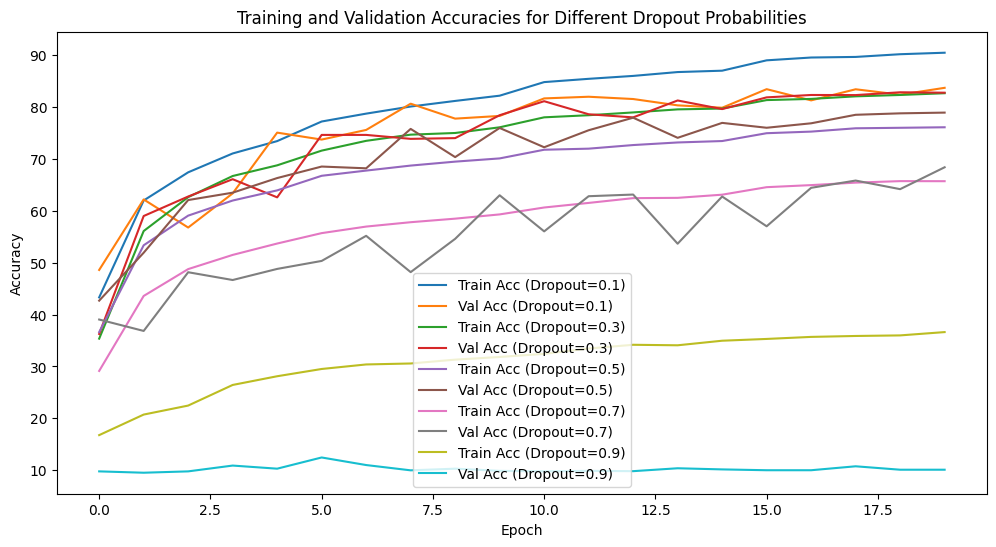

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
import matplotlib.pyplot as plt

def train_and_evaluate_dropout(dropout_values, q3a_config):
    train_accuracies_all = []
    val_accuracies_all = []

    for drop_prob in dropout_values:
        print(f'Training with dropout probability: {drop_prob}')

        # Update the dropout probability in the model configuration
        q3a_config['model_args']['drop_prob'] = drop_prob

        # Initialize data loaders
        datamodule_class = q3a_config['datamodule']
        data_args = q3a_config['data_args']

        dm = datamodule_class(**data_args)
        train_data_loader = dm.get_loader()
        valid_data_loader = dm.get_heldout_loader()

        test_data_args = deepcopy(data_args)
        test_data_args['training'] = False
        test_data_args['shuffle'] = False
        test_data_args['heldout_split'] = 0.0

        test_dm = datamodule_class(**test_data_args)
        test_loader = test_dm.get_loader()

        # Initialize trainer
        trainer_class = q3a_config['trainer_module']
        trainer_cnn = trainer_class(
            config=q3a_config,
            log_dir=ospj(PROJECT_ROOT, 'Logs'),
            train_loader=train_data_loader,
            eval_loader=valid_data_loader,
        )

        # Train the model
        train_accuracies, val_accuracies = trainer_cnn.train()

        # Append the accuracies for plotting later
        train_accuracies_all.append(train_accuracies)
        val_accuracies_all.append(val_accuracies)

        # Evaluate the model on the test set
        monitor_mode, monitor_metric = q3a_config['trainer_config']['monitor'].split()
        drop_prob_str = str(drop_prob).replace('.', '_')
        path = f'/content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_CNN_Dropout_01/best_{monitor_metric}_model_{drop_prob_str}.pth'

        trainer_cnn.load_model(path=path)
        result = trainer_cnn.evaluate(loader=test_loader)

        print()
        print('Data augmented, only cropped images.')
        print(f'Results from best {monitor_metric} model with dropout {drop_prob}:')
        print(result)
        print()

    return train_accuracies_all, val_accuracies_all

def plot_accuracies(dropout_values, train_accuracies_all, val_accuracies_all):
    plt.figure(figsize=(12, 6))

    for i, drop_prob in enumerate(dropout_values):
        plt.plot(train_accuracies_all[i], label=f'Train Acc (Dropout={drop_prob})')
        plt.plot(val_accuracies_all[i], label=f'Val Acc (Dropout={drop_prob})')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies for Different Dropout Probabilities')
    plt.legend()
    plt.show()

dropout_values = [0.1, 0.3, 0.5, 0.7, 0.9]
q3b_config = cnn_cifar10.q3b_dropout_experiment

train_accuracies_all, val_accuracies_all = train_and_evaluate_dropout(dropout_values, q3b_config)
plot_accuracies(dropout_values, train_accuracies_all, val_accuracies_all)




Q3 Report

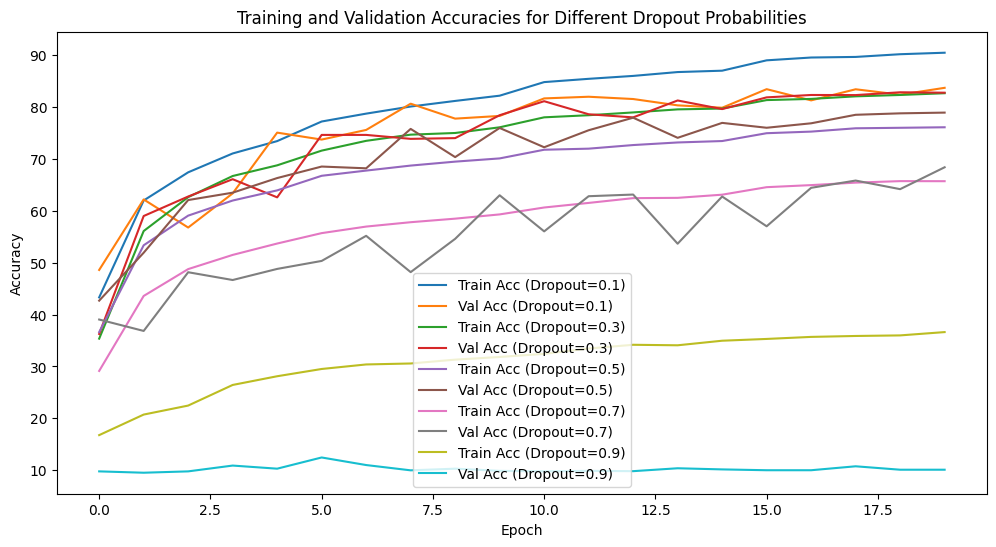

In [ ]:
def plot_accuracies(dropout_values, train_accuracies_all, val_accuracies_all):
    plt.figure(figsize=(12, 6))

    for i, drop_prob in enumerate(dropout_values):
        plt.plot(train_accuracies_all[i], label=f'Train Acc (Dropout={drop_prob})')
        plt.plot(val_accuracies_all[i], label=f'Val Acc (Dropout={drop_prob})')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies for Different Dropout Probabilities')
    plt.legend()
    plt.show()


plot_accuracies(dropout_values, train_accuracies_all, val_accuracies_all)

## Q3 report

Wirte your report for Q3 in this cell. Feel free to add extra code cells

<br>
<br>
<br>

In [ ]:
def plot_accuracies(dropout_values, train_accuracies_all, val_accuracies_all):
    plt.figure(figsize=(12, 6))

    for i, drop_prob in enumerate(dropout_values):
        plt.plot(train_accuracies_all[i], label=f'Train Acc (Dropout={drop_prob})')
        plt.plot(val_accuracies_all[i], label=f'Val Acc (Dropout={drop_prob})')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies for Different Dropout Probabilities')
    plt.legend()
    plt.show()


plot_accuracies(dropout_values, train_accuracies_all, val_accuracies_all)

# Question 4: Use pretrained networks (10 points)

It has become standard practice in computer vision tasks related to images to use a convolutional network pre-trained as the backbone feature extraction network and train new layers on top for the target task. In this question, we will implement such a model. We will use the `VGG_11_bn` network from the `torchvision.models` library as our backbone network. This model has been trained on ImageNet, achieving a top-5 error rate of 10.19%. It consists of 8 convolutional layers followed by adaptive average pooling and fully-connected layers to perform the classification. We will get rid of the average pooling and fully-connected layers from the `VGG_11_bn` model and attach our own fully connected layers to perform the CIFAR-10 classification.

a) Instantiate a pretrained version of the `VGG_11_bn` model with ImageNet pre-trained weights. Add two fully connected layers on top, with Batch Norm and ReLU layers in between them, to build the CIFAR-10 10-class classifier. Note that you will need to set the correct mean and variance in the data-loader, to match the mean and variance the data was normalized with when the `VGG_11_bn` was trained. Train only the newly added layers while disabling gradients for the rest of the network. Each parameter in PyTorch has a required grad flag, which can be turned off to disable gradient computation for it. Get familiar with this gradient control mechanism in PyTorch and train the above model. As a reference point, you will see validation accuracies in the range (61-65%) if implemented correctly. (6 points)

b) We can see that while the ImageNet features are useful, just learning the new layers does not yield better performance than training our own network from scratch. This is due to the domain-shift between the ImageNet dataset (224x224 resolution images) and the CIFAR-10 dataset (32x32 images). To improve the performance we can fine-tune the whole network on the CIFAR-10 dataset, starting from the ImageNet initialization (set `"fine_tune"` to `true` in `vgg_cifar10.py`). To do this, enable gradient computation to the rest of the network, and update all the model parameters. Additionally train a baseline model where the entire network is trained from scratch, without loading the ImageNet weights (set `"weights"` to `None` in `vgg_cifar10.py`). Compare the two models' training curves, validation, and testing performance in the report. (4 points)


If you're using Pytorch 1, the `weights` argument will not work. In that case, you need to change the `weights` argument to `pretrained=True` or `False`. Feel free to post on Forum if you have any issues.

For both questions, feel free to modify the data augmentation by defining a new preset and referring to it in the config file. However, make sure that in your experiments you always change only one thing at a time (i.e use the same augmentation for both method A and method B if you're comparing them with each other!)

In [ ]:
from cfgs.exercise_3 import vgg_cifar10
q4_config = vgg_cifar10.q4_dict


datamodule_class = q4_config['datamodule']
data_args = q4_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}


 By default WandB is enabled in config file for `vgg_cifar10.py`. You can set it to false if you don't want to use it. It's not an essential part of the assignment anyway.

In [ ]:
wandb_enabled = q4_config['trainer_config']['wandb']
if wandb_enabled:
    import wandb

    # change entity to your wandb username/group name. Also feel free to rename project and run names.
    run = wandb.init(
        project="HLCV-exercise-3", # Change the project name if you wish.
        name=q4_config['name'],
        config=q4_config,
        entity="Curious Puffin", # Replace the curious puffin with your WandB username :)
        dir=PROJECT_ROOT
    )
    run.name = run.name + f'-{run.id}'
    assert run is wandb.run


In [ ]:
trainer_class = q4_config['trainer_module']
trainer_vgg = trainer_class(
    config = q4_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_VGG.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_VGG already exists!Existing checkpoints will be overwritten!


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
trainer_vgg.train_vgg()

Train Epoch: 1 Loss: 1.0741: : 100% 45056/45056 [00:21<00:00, 2060.66it/s]
Eval Loss: 1.5913: : 100% 5056/5056 [00:02<00:00, 2307.01it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.6140: : 100% 45056/45056 [00:19<00:00, 2267.81it/s]
Eval Loss: 1.5974: : 100% 5056/5056 [00:02<00:00, 2422.91it/s]


New best at epoch 2


Train Epoch: 3 Loss: 1.7485: : 100% 45056/45056 [00:24<00:00, 1874.26it/s]
Eval Loss: 1.6053: : 100% 5056/5056 [00:02<00:00, 2502.28it/s]


New best at epoch 3


Train Epoch: 4 Loss: 2.3922: : 100% 45056/45056 [00:20<00:00, 2246.54it/s]
Eval Loss: 1.8238: : 100% 5056/5056 [00:02<00:00, 2434.37it/s]
Train Epoch: 5 Loss: 0.5473: : 100% 45056/45056 [00:20<00:00, 2155.09it/s]
Eval Loss: 1.2331: : 100% 5056/5056 [00:02<00:00, 1793.31it/s]
Train Epoch: 6 Loss: 1.6439: : 100% 45056/45056 [00:20<00:00, 2177.61it/s]
Eval Loss: 1.4550: : 100% 5056/5056 [00:02<00:00, 2482.10it/s]
Train Epoch: 7 Loss: 1.2434: : 100% 45056/45056 [00:20<00:00, 2149.84it/s]
Eval Loss: 1.8087: : 100% 5056/5056 [00:02<00:00, 1757.17it/s]


New best at epoch 7


Train Epoch: 8 Loss: 0.8348: : 100% 45056/45056 [00:20<00:00, 2235.60it/s]
Eval Loss: 1.9058: : 100% 5056/5056 [00:02<00:00, 2385.91it/s]
Train Epoch: 9 Loss: 1.3519: : 100% 45056/45056 [00:19<00:00, 2264.91it/s]
Eval Loss: 1.1181: : 100% 5056/5056 [00:02<00:00, 1726.08it/s]
Train Epoch: 10 Loss: 1.6959: : 100% 45056/45056 [00:20<00:00, 2184.10it/s]
Eval Loss: 1.9429: : 100% 5056/5056 [00:02<00:00, 1720.35it/s]
Train Epoch: 11 Loss: 0.3324: : 100% 45056/45056 [00:20<00:00, 2215.45it/s]
Eval Loss: 2.3965: : 100% 5056/5056 [00:03<00:00, 1679.30it/s]
Train Epoch: 12 Loss: 3.0777: : 100% 45056/45056 [00:20<00:00, 2188.79it/s]
Eval Loss: 2.7139: : 100% 5056/5056 [00:02<00:00, 2363.63it/s]
Train Epoch: 13 Loss: 1.2413: : 100% 45056/45056 [00:19<00:00, 2297.66it/s]
Eval Loss: 2.0288: : 100% 5056/5056 [00:02<00:00, 2474.51it/s]


Early stopping point reached at epoch 13


([0.5750399502840909,
  0.6247336647727273,
  0.6493918678977273,
  0.6701216264204546,
  0.6876997514204546,
  0.7057883522727273,
  0.7219904119318182,
  0.7401899857954546,
  0.7525079900568182,
  0.7660910866477273,
  0.7794078480113636,
  0.7899280894886364,
  0.7997602982954546],
 [0.6327136075949367,
  0.6402294303797469,
  0.6536787974683544,
  0.651503164556962,
  0.6517009493670886,
  0.6431962025316456,
  0.65625,
  0.6439873417721519,
  0.6463607594936709,
  0.6394382911392406,
  0.6331091772151899,
  0.635878164556962,
  0.6384493670886076])

In [ ]:
# Change this to the experiment you want to evaluate
path = '/content/drive/MyDrive/HLCV_stuff/Assignment_3//Saved/CIFAR10_VGG/last_model.pth'
trainer_vgg.load_model(path=path)

result = trainer_vgg.evaluate(loader=test_loader)

print(result)

if wandb_enabled:
    for metrics, values in result.items():
        wandb.run.summary[f"test_{metrics}"] = values

    # Change the title and message as you wish.
    # Would only work if you have enabled push notifications for your email/slack in wandb account settings.
    # Of course not an essential part of the assignment :)
    wandb.alert(
        title="Training Finished",
        text=f'VGG Training has finished. Test results: {result}', level=wandb.AlertLevel.INFO
    )

    run.finish()

Eval Loss: 0.8650: : 100% 10048/10048 [00:04<00:00, 2109.31it/s]

{'loss': 1.1569084570666028, 'top1': 0.6454020700636943, 'top5': 0.9621815286624203}


Part B

In [ ]:
from cfgs.exercise_3 import vgg_cifar10
fine_tune_config = vgg_cifar10.fine_tune_dict


datamodule_class = fine_tune_config['datamodule']
data_args = fine_tune_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

trainer_class = fine_tune_config['trainer_module']

fine_tune_trainer = trainer_class(
    config = fine_tune_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_VGG_FineTune.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_VGG_FineTune already exists!Existing checkpoints will be overwritten!


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:03<00:00, 167MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
fine_tune_train_acc, fine_tune_val_acc = fine_tune_trainer.train_vgg()

Train Epoch: 1 Loss: 1.0801: : 100% 45056/45056 [00:27<00:00, 1655.02it/s]
Eval Loss: 1.2283: : 100% 5056/5056 [00:02<00:00, 2480.01it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.1889: : 100% 45056/45056 [00:26<00:00, 1731.49it/s]
Eval Loss: 1.8998: : 100% 5056/5056 [00:02<00:00, 1937.84it/s]


New best at epoch 2


Train Epoch: 3 Loss: 1.4233: : 100% 45056/45056 [00:24<00:00, 1845.54it/s]
Eval Loss: 0.5527: : 100% 5056/5056 [00:02<00:00, 1713.23it/s]


New best at epoch 3


Train Epoch: 4 Loss: 0.0215: : 100% 45056/45056 [00:24<00:00, 1837.64it/s]
Eval Loss: 1.0329: : 100% 5056/5056 [00:02<00:00, 2457.73it/s]


New best at epoch 4


Train Epoch: 5 Loss: 0.0847: : 100% 45056/45056 [00:25<00:00, 1753.72it/s]
Eval Loss: 1.2272: : 100% 5056/5056 [00:01<00:00, 2618.46it/s]


New best at epoch 5


Train Epoch: 6 Loss: 0.5075: : 100% 45056/45056 [00:25<00:00, 1746.64it/s]
Eval Loss: 1.4297: : 100% 5056/5056 [00:01<00:00, 2606.28it/s]


New best at epoch 6


Train Epoch: 7 Loss: 0.3442: : 100% 45056/45056 [00:25<00:00, 1771.57it/s]
Eval Loss: 1.5365: : 100% 5056/5056 [00:02<00:00, 2373.52it/s]
Train Epoch: 8 Loss: 0.5595: : 100% 45056/45056 [00:24<00:00, 1871.39it/s]
Eval Loss: 1.2498: : 100% 5056/5056 [00:03<00:00, 1663.16it/s]


New best at epoch 8


Train Epoch: 9 Loss: 0.2094: : 100% 45056/45056 [00:24<00:00, 1822.41it/s]
Eval Loss: 0.8216: : 100% 5056/5056 [00:02<00:00, 2226.60it/s]
Train Epoch: 10 Loss: 0.2513: : 100% 45056/45056 [00:25<00:00, 1758.82it/s]
Eval Loss: 0.8570: : 100% 5056/5056 [00:01<00:00, 2567.34it/s]


New best at epoch 10


Train Epoch: 11 Loss: 0.4318: : 100% 45056/45056 [00:24<00:00, 1829.74it/s]
Eval Loss: 0.6332: : 100% 5056/5056 [00:02<00:00, 1977.42it/s]
Train Epoch: 12 Loss: 0.6970: : 100% 45056/45056 [00:25<00:00, 1793.61it/s]
Eval Loss: 1.7735: : 100% 5056/5056 [00:01<00:00, 2631.24it/s]
Train Epoch: 13 Loss: 0.8540: : 100% 45056/45056 [00:25<00:00, 1750.85it/s]
Eval Loss: 1.5952: : 100% 5056/5056 [00:02<00:00, 2509.45it/s]
Train Epoch: 14 Loss: 0.0024: : 100% 45056/45056 [00:24<00:00, 1815.89it/s]
Eval Loss: 1.1342: : 100% 5056/5056 [00:02<00:00, 1896.31it/s]
Train Epoch: 15 Loss: 0.6366: : 100% 45056/45056 [00:23<00:00, 1883.35it/s]
Eval Loss: 2.0693: : 100% 5056/5056 [00:02<00:00, 2035.87it/s]


In [ ]:
from cfgs.exercise_3 import vgg_cifar10
baseline_config = vgg_cifar10.baseline_dict


datamodule_class = baseline_config['datamodule']
data_args = baseline_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

trainer_class = baseline_config['trainer_module']

baseline_trainer = trainer_class(
    config = baseline_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/HLCV_stuff/Assignment_3/Logs/CIFAR10_VGG_Baseline.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/HLCV_stuff/Assignment_3/Saved/CIFAR10_VGG_Baseline already exists!Existing checkpoints will be overwritten!


In [ ]:
baseline_train_acc, baseline_val_acc = baseline_trainer.train_vgg()

Train Epoch: 1 Loss: 1.3606: : 100% 45056/45056 [00:20<00:00, 2233.68it/s]
Eval Loss: 2.2793: : 100% 5056/5056 [00:02<00:00, 1782.38it/s]


New best at epoch 1


Train Epoch: 2 Loss: 1.3597: : 100% 45056/45056 [00:19<00:00, 2322.42it/s]
Eval Loss: 2.1028: : 100% 5056/5056 [00:02<00:00, 1739.86it/s]


New best at epoch 2


Train Epoch: 3 Loss: 2.0177: : 100% 45056/45056 [00:19<00:00, 2324.72it/s]
Eval Loss: 2.2918: : 100% 5056/5056 [00:01<00:00, 2586.06it/s]
Train Epoch: 4 Loss: 1.5540: : 100% 45056/45056 [00:18<00:00, 2375.83it/s]
Eval Loss: 2.4037: : 100% 5056/5056 [00:02<00:00, 2487.22it/s]


New best at epoch 4


Train Epoch: 5 Loss: 1.0693: : 100% 45056/45056 [00:20<00:00, 2158.27it/s]
Eval Loss: 2.0273: : 100% 5056/5056 [00:01<00:00, 2601.53it/s]


New best at epoch 5


Train Epoch: 6 Loss: 1.9904: : 100% 45056/45056 [00:19<00:00, 2321.35it/s]
Eval Loss: 2.7253: : 100% 5056/5056 [00:02<00:00, 2434.38it/s]
Train Epoch: 7 Loss: 1.9013: : 100% 45056/45056 [00:19<00:00, 2349.67it/s]
Eval Loss: 2.4690: : 100% 5056/5056 [00:02<00:00, 1792.48it/s]
Train Epoch: 8 Loss: 1.7791: : 100% 45056/45056 [00:19<00:00, 2348.14it/s]
Eval Loss: 3.5084: : 100% 5056/5056 [00:01<00:00, 2658.90it/s]
Train Epoch: 9 Loss: 2.4285: : 100% 45056/45056 [00:19<00:00, 2365.77it/s]
Eval Loss: 2.4265: : 100% 5056/5056 [00:01<00:00, 2579.54it/s]
Train Epoch: 10 Loss: 2.5943: : 100% 45056/45056 [00:20<00:00, 2228.09it/s]
Eval Loss: 2.8172: : 100% 5056/5056 [00:02<00:00, 2445.28it/s]
Train Epoch: 11 Loss: 0.8809: : 100% 45056/45056 [00:20<00:00, 2214.49it/s]
Eval Loss: 3.2062: : 100% 5056/5056 [00:03<00:00, 1672.72it/s]
Train Epoch: 12 Loss: 1.2335: : 100% 45056/45056 [00:18<00:00, 2380.26it/s]
Eval Loss: 2.7745: : 100% 5056/5056 [00:01<00:00, 2574.91it/s]
Train Epoch: 13 Loss: 2.9708: :

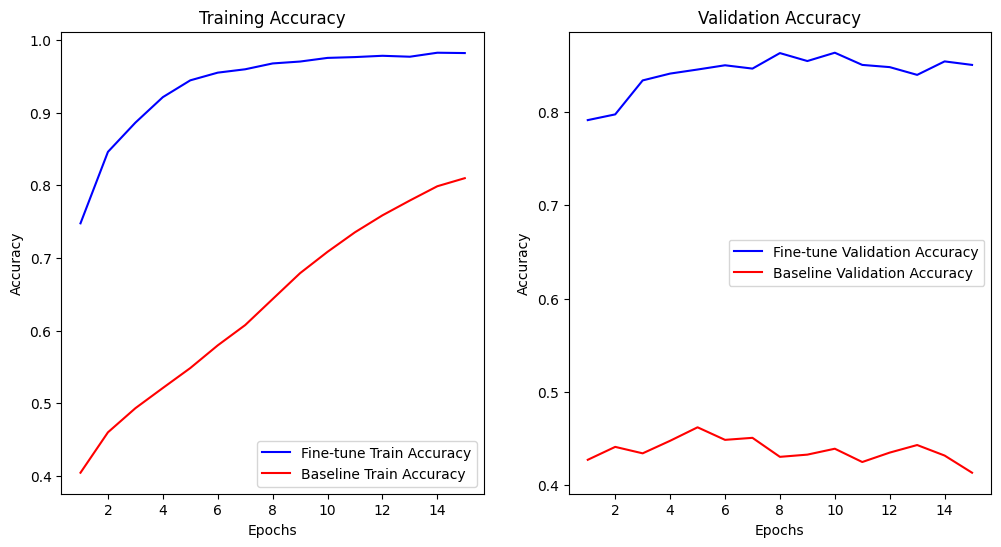

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Training Curves
epochs = range(1, len(fine_tune_train_acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, fine_tune_train_acc, 'b', label='Fine-tune Train Accuracy')
plt.plot(epochs, baseline_train_acc, 'r', label='Baseline Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, fine_tune_val_acc, 'b', label='Fine-tune Validation Accuracy')
plt.plot(epochs, baseline_val_acc, 'r', label='Baseline Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Write your report for Q4 in this cell.
Feel free to add more code cells if needed.

<br>
<br>
<br>



Validation Accuracy: The ‘Fine-tune Validation Accuracy’  fluctuates slightly but trends upward from just above 0.8 to nearly 1.0, while the ‘Baseline Validation Accuracy’ (red line) remains around 0.5, indicating better generalization with fine-tuning.

Overfitting Check: High validation accuracy is also a check against overfitting. If the training accuracy is high but the validation accuracy is low, it could mean the model is memorizing the training data and failing to generalize. However, in this case, since both fine-tune training and validation accuracies are high, it indicates that the model is learning patterns that generalize well.

The fine-tuned model’s high validation accuracy implies it has learned well from the training data and can predict accurately when faced with new, unseen data.